## Preliminaries

In [ ]:
!pip install unsloth Levenshtein -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.9 MB/s eta 0:00:00


In [ ]:
import unsloth
print(unsloth.__version__)
import torch
import numpy as np
from datasets import load_dataset
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
import re
# from Levenshtein import ratio

2025.7.8


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%pip install python-dotenv

In [9]:
from dotenv import load_dotenv
import os
load_dotenv("/content/drive/MyDrive/Colab Notebooks/LLMs/4032/API.env")

huggingface_token = os.getenv("huggingface_moradilakbusiness")
huggingface_token[:8]

'hf_AZcfw'

In [10]:
!huggingface-cli whoami

Not logged in


In [11]:
from huggingface_hub import login
!huggingface-cli logout
login(token=huggingface_token)
!huggingface-cli whoami

Not logged in!
moradilakbusiness


In [ ]:
class CONFIG:
    seed = 42
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_name = "unsloth/Llama-3.2-3B-Instruct-bnb-4bit"
    reward_model_name = "nicolinho/QRM-Llama3.1-8B-v2"
    benchmark_name = "openai/gsm8k"

    train_data_size = 1600
    benchmark_subset_size = 50
    max_seq_length = 1024
    train_batch_size = 2
    gradient_accumulation_steps = 4
    epochs = 1

    # LoRA Configs
    lora_rank = 64,
    lora_alpha = 64,
    use_gradient_checkpointing = "unsloth"
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],

    dpo_output_dir = "llama-3.2-3b-dpo-checkpoint"
    orpo_output_dir = "llama-3.2-3b-orpo-checkpoint"

device = CONFIG.device
device

device(type='cuda')

### Load Model & Tokenizer (2.5 points)

- Load `Llama-3.2-3B-Instruct-bnb-4bit` model using `unsloth` for inference.

In [ ]:
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template

def load_model_and_tokenizer(model_id, max_seq_length):
    print("Loading model and tokenizer using unsloth...")
    model, tokenizer = FastLanguageModel.from_pretrained(model_id, max_seq_length=max_seq_length, load_in_4bit=True, dtype = None)
    tokenizer = get_chat_template(
        tokenizer,
        chat_template="llama-3.1",
        map_eos_token = True,
    )
    return model, tokenizer

In [ ]:
model, tokenizer = load_model_and_tokenizer(CONFIG.model_name, CONFIG.max_seq_length)

Loading model and tokenizer using unsloth...
==((====))==  Unsloth 2025.7.8: Fast Llama patching. Transformers: 4.53.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


### Load benchmark (2.5 points)

In [ ]:
def load_gsm8k_dataset():
    """Load the GSM8K dataset from HuggingFace."""
    dataset = load_dataset(CONFIG.benchmark_name, "main")
    return dataset

def create_sample_dataset(dataset, num_samples, seed):
    """Create a fixed sample dataset for evaluation."""
    np.random.seed(seed)
    indices = np.random.choice(len(dataset["test"]), num_samples, replace=False)
    sample_test = [dataset["test"][int(i)] for i in indices]
    return sample_test

In [ ]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load dataset
dataset = load_gsm8k_dataset()

# Select subset
sample_dataset = create_sample_dataset(dataset, num_samples=CONFIG.benchmark_subset_size-45, seed=CONFIG.seed)

In [ ]:
# Display one sample
sample_dataset[0]

{'question': 'Carol and Jennifer are sisters from Los Angeles who love collecting signatures from celebrities. During their summer break from school, the sisters spend every afternoon collecting signatures. After five weeks, Carol and Jennifer compare their autograph books, counting up the number of signatures each sister has collected. Carol has 20 signatures in her book, and Jennifer has 44. The sisters have three more weeks of summer vacation, and they decide they want to reach 100 signatures between them by the end of the summer. How many signatures do the sisters need to collect to reach their goal?',
 'answer': 'Carol and Jennifer have already collected 20 + 44 signatures = <<20+44=64>>64 signatures.\nSince their goal is 100, they need to collect 100 - 64 signatures. 100 - 64 = <<100-64=36>>36 signatures\n#### 36'}

### Prompt Engineering (10 points)

Implement different prompting strategies for in-context learning.
At least four of the following methods should be implemented (including baseline):
- Zero-shot (**Baseline**)
- Role-play prompting [[paper](https://aclanthology.org/2024.naacl-long.228/)]
- Zero-shot CoT [[paper](https://arxiv.org/abs/2205.11916)]
- Few-shot CoT
- Least-to-Most prompting [[paper](https://arxiv.org/abs/2205.10625)]
- Generated Knowledge prompting [[paper](https://aclanthology.org/2022.acl-long.225/)]
- Any other idea to improve performance (**Optional**)

Additionally, if performance exceeds 80%, **two extra points** are awarded for every 5% improvement. You can try other methods or a combination of existing ones.

<a id="prompt-engineering"></a>

In [ ]:
# def create_prompts(question, examples=examples):
def create_prompts(question):
    """Generate various prompt types for a given question."""

    # default
    default = (
        f"{question}"
    )

    default_gpt = (
        f"""### Question: {question}

 ### Answer:"""
    )

    # Zero-shot (Baseline)
    zero_shot = (
        f"Problem: {question}"
        "\n\nThe total answer number is: "
    )

    # Role-play prompting
    role_prompting = (
        "You are a highly skilled mathematician. Carefully analyze the following problem and provide the correct answer then tell the total answer number and Your detailed solution."
        f"\n\nProblem: {question}"
        "\n\nThe total answer number is: "
    )

    # Zero-shot Chain-of-Thought (CoT)
    zero_shot_cot = (
        f"Problem: {question}"
        "\n\nLet's think step by step before arriving at the total answer.\n\nThe total answer number is: "
    )

    # Least-to-Most Prompting
    least_to_most_prompting = (
        f"To solve the problem \"{question}\", let's first break it into smaller subproblems."
        "\nStep 1: Identify the main components."
        "\nStep 2: Solve each component separately."
        "\nStep 3: Combine the results to get the total answer."
        "\n\nThe total answer number is: "
    )

    return {
        "default": default,
        "default_gpt": default_gpt,
        "Baseline": zero_shot,
        "Role-Prompting": role_prompting,
        "Zero-shot CoT": zero_shot_cot,
        "Least-to-Most": least_to_most_prompting,
    }

In [ ]:
question = "A team of 4 painters worked on a mansion for 3/8ths of a day every day for 3 weeks. How many hours of work did each painter put in?"
a= create_prompts(question)
for i in a:
    print('@@@@\n', i, ':\n', a[i])

@@@@
 default :
 A team of 4 painters worked on a mansion for 3/8ths of a day every day for 3 weeks. How many hours of work did each painter put in?
@@@@
 default_gpt :
 ### Question: A team of 4 painters worked on a mansion for 3/8ths of a day every day for 3 weeks. How many hours of work did each painter put in?

 ### Answer:
@@@@
 Baseline :
 Problem: A team of 4 painters worked on a mansion for 3/8ths of a day every day for 3 weeks. How many hours of work did each painter put in?

The total answer number is: 
@@@@
 Role-Prompting :
 You are a highly skilled mathematician. Carefully analyze the following problem and provide the correct answer then tell the total answer number and Your detailed solution.

Problem: A team of 4 painters worked on a mansion for 3/8ths of a day every day for 3 weeks. How many hours of work did each painter put in?

The total answer number is: 
@@@@
 Zero-shot CoT :
 Problem: A team of 4 painters worked on a mansion for 3/8ths of a day every day for 3 wee

In [ ]:
def extract_answer(text):
    """Extract the final numerical answer from the model's output."""
    # match = re.search(r'(?<=#### )[\d,]+', text) # group(0)
    match = re.search(r'####\s*([\d,]+)', text)
    if match:
        answer = match.group(1).replace(',', '')
        return float(answer)
    return "not found!"

def extract_answer2(text):
    match = re.search(r'[-+]?[\d,]*\.?\d+', text)
    if match:
        answer = match.group(0).replace(',', '')
        if answer == '':
            return "number not found!"
        return float(answer)
    return "number not found!"

def extract_answer3(text):
    match = re.search(r'The total answer number is:\s*([\d,]+)', text)
    if match:
        answer = match.group(1).replace(',', '')
        return float(answer)
    return "not found!"
65960, 4545

(65960, 4545)

In [ ]:
import re
a= extract_answer(" 56,422  xxx vvcxv  dvd dsd...zxczzxczxc <<95 060-29100=65960>>65,960 more dollars...\n#### 65,960")
b= extract_answer2("  **45,45**   xxx vvcxv  dvd dsd...zxczzxczxc <<95 060-29100=65960>>65,960 more dollars...\n#### 65,960")
c= extract_answer3('  467,87 You are a highly skilled mathematician. sisters need to collect to reach their goal?\n\nThe total answer number is: 564,456**\n\nHere is my detailed solution')
a, b, c

(65960.0, 4545.0, 564456.0)

In [ ]:
from tqdm import tqdm
def evaluate_prompts(model, tokenizer, sample_dataset, seed=42):
  """Evaluate all prompt variations on the provided sample dataset."""
  # WRITE YOUR CODE HERE
  results = {}
  all_prompts_of_samples = []
  corrects = {}
  for prompt_type in create_prompts(''):
    corrects[prompt_type] = 0

  for sample in tqdm(sample_dataset):
    for prompt_type, prompt in create_prompts(sample["question"]).items():
      actual_answer = extract_answer(sample["answer"])
      inputs = tokenizer(prompt, return_tensors="pt").to(CONFIG.device)
      if prompt_type == "Few-shot CoT":
        output = model.generate(**inputs, max_length=1024)
      else:
        output = model.generate(**inputs, max_length=256)
      response = tokenizer.decode(output[0], skip_special_tokens=True)
      response = response[len(prompt):]
      predicted_answer = extract_answer2(response)

      all_prompts_of_samples.append({
        "prompt_type": prompt_type,
        "question": sample["question"],
        "answer": sample["answer"],
        "model_answer": response,
        "predicted_answer": predicted_answer,
        "actual_answer": actual_answer,
        })
      if predicted_answer == actual_answer:
        corrects[prompt_type] += 1
        print(f"\n_______________________________ @: {predicted_answer},   pType: {prompt_type}")
      else:
        print(f"\n$: pa {predicted_answer}, aa {actual_answer},  pType: {prompt_type}")

  for prompt_type in corrects:
    results[prompt_type] = corrects[prompt_type] / len(sample_dataset)

  return results, all_prompts_of_samples

In [ ]:
print("Accuracy by prompting method:")
accuracy, all_samples = evaluate_prompts(model, tokenizer, sample_dataset[:CONFIG.benchmark_subset_size-45-2])

# WRITE YOUR CODE HERE
print(accuracy)


Accuracy by prompting method:


  0%|          | 0/3 [00:00<?, ?it/s]


$: pa 1.0, aa 36.0,  pType: default

$: pa number not found!, aa 36.0,  pType: default_gpt

$: pa 76.0, aa 36.0,  pType: Baseline

$: pa 20.0, aa 36.0,  pType: Role-Prompting

$: pa 136.0, aa 36.0,  pType: Zero-shot CoT


 33%|███▎      | 1/3 [00:49<01:39, 49.84s/it]


$: pa 56.0, aa 36.0,  pType: Least-to-Most

$: pa 1.0, aa 189.0,  pType: default

$: pa number not found!, aa 189.0,  pType: default_gpt

$: pa 1050.0, aa 189.0,  pType: Baseline

$: pa 12.0, aa 189.0,  pType: Role-Prompting

$: pa 4320.0, aa 189.0,  pType: Zero-shot CoT


 67%|██████▋   | 2/3 [01:55<00:58, 58.86s/it]


$: pa 108.0, aa 189.0,  pType: Least-to-Most

$: pa 1.0, aa 65960.0,  pType: default

$: pa number not found!, aa 65960.0,  pType: default_gpt

$: pa 29370.0, aa 65960.0,  pType: Baseline

$: pa 0.0, aa 65960.0,  pType: Role-Prompting

$: pa 96430.0, aa 65960.0,  pType: Zero-shot CoT


100%|██████████| 3/3 [03:04<00:00, 61.50s/it]


$: pa 2.0, aa 65960.0,  pType: Least-to-Most
{'default': 0.0, 'default_gpt': 0.0, 'Baseline': 0.0, 'Role-Prompting': 0.0, 'Zero-shot CoT': 0.0, 'Least-to-Most': 0.0}


In [ ]:
# gpt

correct = 0
total = 0
wrong_answers = []

for example in sample_dataset:
    question = example["question"]
    answer = example["answer"]
    gold_answer = answer.split("####")[-1].strip()

    prompt = create_prompts(question)
    inputs = tokenizer(prompt['default_gpt'], return_tensors="pt").to(model.device)
    output = model.generate(**inputs, max_new_tokens=256)

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    match = re.findall(r"[-+]?\d+(?:\.\d+)?", decoded.split("### Answer:")[-1])
    pred_answer = match[-1].strip() if match else "N/A"

    total += 1
    if pred_answer == gold_answer:
        correct += 1
    else:
        wrong_answers.append({
            "question": question,
            "answer": answer,
            "predicted": pred_answer,
            "gold": gold_answer,
            "model_answer": decoded
        })

accuracy = correct / total
print(f"Accuracy on {total} samples: {accuracy*100:.2f}%")

Accuracy on 5 samples: 0.00%


In [ ]:
wrong_answers[:2]

[{'question': 'Carol and Jennifer are sisters from Los Angeles who love collecting signatures from celebrities. During their summer break from school, the sisters spend every afternoon collecting signatures. After five weeks, Carol and Jennifer compare their autograph books, counting up the number of signatures each sister has collected. Carol has 20 signatures in her book, and Jennifer has 44. The sisters have three more weeks of summer vacation, and they decide they want to reach 100 signatures between them by the end of the summer. How many signatures do the sisters need to collect to reach their goal?',
  'answer': 'Carol and Jennifer have already collected 20 + 44 signatures = <<20+44=64>>64 signatures.\nSince their goal is 100, they need to collect 100 - 64 signatures. 100 - 64 = <<100-64=36>>36 signatures\n#### 36',
  'predicted': '100',
  'gold': '36',
  'model_answer': '### Question: Carol and Jennifer are sisters from Los Angeles who love collecting signatures from celebritie

In [ ]:
# gpt

import json
with open("wrong_answers.json", "w") as f:
    json.dump(wrong_answers, f, indent=2)

In [ ]:
all_samples[:2]

[{'prompt_type': 'default',
  'question': 'Carol and Jennifer are sisters from Los Angeles who love collecting signatures from celebrities. During their summer break from school, the sisters spend every afternoon collecting signatures. After five weeks, Carol and Jennifer compare their autograph books, counting up the number of signatures each sister has collected. Carol has 20 signatures in her book, and Jennifer has 44. The sisters have three more weeks of summer vacation, and they decide they want to reach 100 signatures between them by the end of the summer. How many signatures do the sisters need to collect to reach their goal?',
  'answer': 'Carol and Jennifer have already collected 20 + 44 signatures = <<20+44=64>>64 signatures.\nSince their goal is 100, they need to collect 100 - 64 signatures. 100 - 64 = <<100-64=36>>36 signatures\n#### 36',
  'model_answer': ' \n\n## Step 1: Calculate the total number of signatures Carol and Jennifer have collected so far.\nCarol has 20 signa

# Human Preference Alignment (80 Points)

In [ ]:
pip install trl bert-score transformers -qqq

In [ ]:
from trl import PPOTrainer
from transformers import AutoModelForCausalLM, AutoTokenizer

# Model: reformulator
model = AutoModelForCausalLM.from_pretrained("llama-3-1B")
tokenizer = AutoTokenizer.from_pretrained("llama-3-1B")

ppo_trainer = PPOTrainer(model=model, tokenizer=tokenizer) # ...

for original_prompt, correct_answer in dataset:
    # Generate reformulated prompt
    reformulated_prompt = model.generate(original_prompt)

    # Feed reformulated prompt to responder
    response = responder.generate(reformulated_prompt)

    # Compare response to correct_answer
    reward = compute_reward(response, correct_answer)

    # Train reformulator
    ppo_trainer.step([original_prompt], [reformulated_prompt], [reward])


In [ ]:
def compute_reward(original_prompt, reformulated_prompt, response, correct_response):
    reward = 0
    if response == correct_response:
        reward += 1.0

    if len(reformulated_prompt) < len(original_prompt):
        reward += 0.2

    reward += compute_semantic_similarity(original_prompt, reformulated_prompt)

    return reward

In [ ]:
from bert_score import score

def compute_semantic_similarity(original_prompt, reformulated_prompt):
    P, R, F1 = score([reformulated_prompt], [original_prompt], lang="en", verbose=False)

    similarity_score = F1[0].item()

    print(f"Similarity Score (BERTScore F1): {similarity_score:.4f}")

    if similarity_score > 0.85:
        reward = 0.3
    elif similarity_score > 0.7:
        reward = 0.1
    else:
        reward = 0.0

    return reward


In [ ]:
## test compute_reward
a = "If a dozen apples cost $3.60, what is the cost of one apple?"
b = "What is the price for one apple if 12 cost $3.60?"
compute_reward(a, b, 4, 4)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Similarity Score (BERTScore F1): 0.9432


1.5

## RLHF Flow

<img src="https://huyenchip.com/assets/pics/rlhf/6-sft-rlhf.png" width="80%">

With the rise of **ChatGPT**, **Reinforcement Learning from Human Feedback (RLHF)** has gained significant attention in both academic and industrial language modeling communities.

The approach dates back to **OpenAI’s 2019 paper**:  
[Fine-Tuning Language Models from Human Preferences](https://arxiv.org/abs/1909.08593).  

A year later, OpenAI demonstrated RLHF’s effectiveness in **natural language generation**:  
[Learning to Summarize from Human Feedback](https://arxiv.org/abs/2009.01325).  

This research showed that fine-tuning alone leads to **suboptimal human-aligned performance**. RLHF optimizes models using human feedback, significantly improving their output quality.


## Reward Models (20 Points)

### Inference from the Reward Model (10 points)

- Load the [reward model](https://huggingface.co/nicolinho/QRM-Llama3.1-8B-v2) and its tokenization

In [ ]:
# WRITE YOUR CODE
model = AutoModelForSequenceClassification.from_pretrained(CONFIG.reward_model_name, torch_dtype=torch.bfloat16, device_map=device, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(CONFIG.reward_model_name, use_fast=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

modeling_custom.py:   0%|          | 0.00/8.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nicolinho/QRM-Llama3.1-8B-v2:
- modeling_custom.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/143M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at nicolinho/QRM-Llama3.1-8B-v2 were not used when initializing LlamaForRewardModelWithGating: ['score.weight']
- This IS expected if you are initializing LlamaForRewardModelWithGating from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LlamaForRewardModelWithGating from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

In [ ]:
def generate_reward_score(prompt, response, model=model, tokenizer=tokenizer):
    messages = [{"role": "user", "content": prompt},
            {"role": "assistant", "content": response}]
    input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model(input_ids)
        score = output.score.cpu().float()
        rewards = output.rewards.cpu().float()
        gating_coeffs = output.gating_output.cpu().float()
    return score, rewards, gating_coeffs

In [ ]:
print("Available output fields:", output.keys())

Available output fields: odict_keys(['reward_quantiles', 'rewards', 'hidden_state', 'prompt_embedding', 'gating_output', 'score', 'logits'])


- Generate reward scores for both responses.

In [ ]:
# Prompt and responses
sample_prompt = "Do wooden pencils contain lead as their core?"
chosen_response = "No, wooden pencils do not contain lead in their core. The term \"lead\" is a misnomer, as wooden pencils actually use graphite for their core. Graphite was historically called \"black lead\" due to its appearance, leading to the common misconception that pencils contain lead."
rejected_response = "Yes, wooden pencils typically contain a core made of graphite and clay, which is commonly referred to as \"lead\" despite not being made of actual lead."

# WRITE YOUR CODE HERE
chosen_response_score, chosen_response_rewards, gating_coeffs = generate_reward_score(sample_prompt, chosen_response)
rejected_response_score, rejected_response_rewards, gating_coeffs = generate_reward_score(sample_prompt, rejected_response)
print(f"chosen response score:   {chosen_response_score.item():.4f}\nrejected response score: {rejected_response_score.item():.4f}")

chosen response score:   0.9416
rejected response score: 0.8311


- Visualize the results:

    + Create a bar chart comparing the reward scores of the chosen vs. the rejected response for each attribute.
    + Overlay a line chart representing the gating output coefficients.

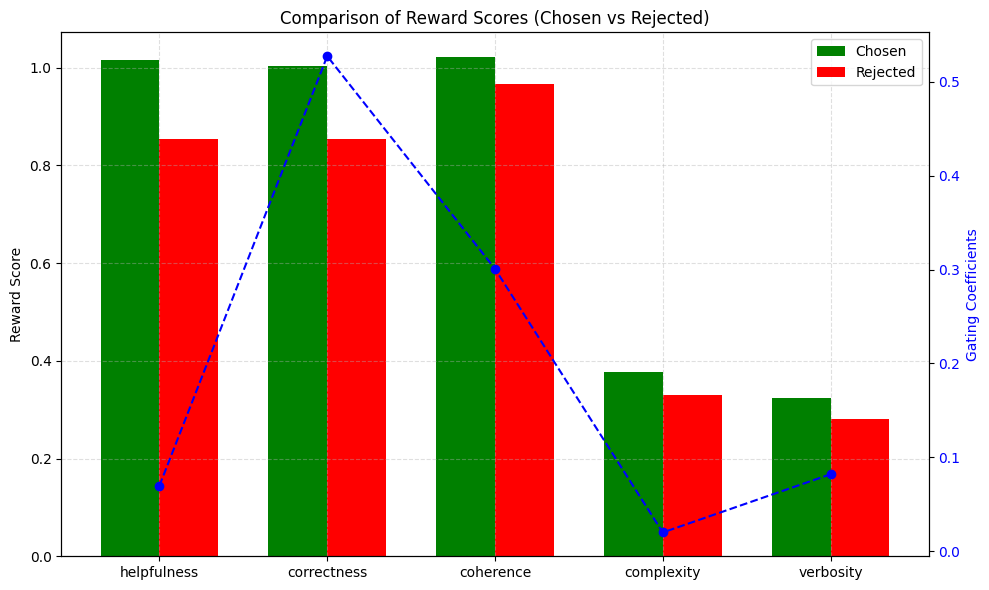

In [ ]:
# The attributes of the 5 reward objectives
attributes = ['helpfulness','correctness','coherence', 'complexity','verbosity']

# WRITE YOUR CODE HERE
chosen_scores = chosen_response_rewards.squeeze().numpy()
rejected_scores = rejected_response_rewards.squeeze().numpy()

x = np.arange(len(attributes))
fig, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.35
ax1.bar(x - bar_width/2, chosen_scores, width=bar_width, label='Chosen', color='green')
ax1.bar(x + bar_width/2, rejected_scores, width=bar_width, label='Rejected', color='red')

ax1.set_ylabel('Reward Score')
ax1.set_title('Comparison of Reward Scores (Chosen vs Rejected)')
ax1.set_xticks(x)
ax1.set_xticklabels(attributes)
ax1.legend(loc='upper right')
ax1.grid(True, linestyle='--', alpha=0.4)

ax2 = ax1.twinx()
ax2.plot(x, gating_coeffs[0], label='Gating Coefficients', color='blue', marker='o', linestyle='--')
ax2.set_ylabel('Gating Coefficients', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.tight_layout()
plt.show()

## PPO (15 Points)

### Question 4 (5 points):
**a)** Describe the Proximal Policy Optimization (PPO) algorithm and explain its role in the Reinforcement Learning from Human Feedback (RLHF) framework.

**b)** Specifically, is PPO an on-policy or off-policy algorithm, and why is this characteristic important for its application in RLHF?

`# WRITE YOUR ANSWER HERE`
<div dir=rtl>
<h1>پاسخ a</h1>
PPO یک روش بهینه‌سازی سیاست در یادگیری تقویتی است که با هدف پایداری آموزش و جلوگیری از تغییرات شدید در سیاست طراحی شده است. مکانیسم اصلی PPO مبتنی بر تابع هدف جایگزین است که با اعمال یک محدودیت روی نسبت احتمالات، از به‌روزرسانی‌های بیش‌ازحد بزرگ جلوگیری می‌کند. این محدودیت تضمین می‌کند که سیاست جدید بیش‌ازحد از سیاست قدیمی فاصله نگیرد. به نحوی که سیاست آپدیت‌های کوتاه‌تر در طول یادگیری، احتمال بیشتری برای همگرا شدن به راه‌حل بهینه دارد. در مقابل؛ آپدیت‌های طولانی ممکن است منجر  به شکست و یا حتی سیاستی بد و غلط شود که راه بازگشت از آن ممکن نباشد (مانند افتادن از بالای کوه در دره) یا حداقل برای بازگشت نیاز به یک زمان طولانی داشته باشد. در واقع مدل پاسخ‌های جدید را با پاسخ‌های قبلی مدل مقایسه می‌کنه اگر مدل جدید بهتر باشه، پارامترهای آن را به مدل قبلی نزدیک می‌کنه و این فرآیند بارها تکرار می‌شه تا مدل بهبود پیدا کنه و جلوگیری کردن از تغیرات شدید پارامترها هم باعث پایداری یادگیری مدل میشه.

در RLHF، ابتدا یک مدل پاداش با استفاده از ترجیحات انسانی آموزش داده می‌شود. سپس PPO برای بهینه‌سازی سیاست ایجنت (مثلاً یک مدل زبانی) بر اساس این مدل پاداش استفاده می‌شود، که در واقع نقش PPO در RLHF تنظیم کردن خروجی مدل زبانی با ترجیحات انسانی است که باعث می‌شود مدل پاسخ‌های بد را کمتر تولید کند و پاسخ‌های خوب را بیشتر تولید کند؛ در عمل، این کار طی چندین مرحله تکرار می‌شود تا مدل عملکرد بهتری داشته باشد.

<h1>پاسخ b</h1>
به طور خاص PPO یک الگوریتم On-Policy است، زیرا برای محاسبه گرادیان‌ها به داده‌های تولیدشده توسط نسخه فعلی سیاست نیاز دارد. در هر تکرار آموزشی، داده‌ها با سیاست کنونی جمع‌آوری و سپس برای به‌روزرسانی استفاده می‌شوند.


<h2>اهمیت این ویژگی در RLHF</h2>

هماهنگی با مدل پاداش: در RLHF، مدل پاداش بر اساس ترجیحات انسانی آموزش می‌بیند که ممکن است به رفتار سیاست فعلی وابسته باشد. استفاده از داده‌های On-Policy تضمین می‌کند که بازخوردها با عملکرد کنونی ایجنت مرتبط هستند.

جلوگیری از بایاس: داده‌های Off-Policy (مثلاً از سیاست‌های قدیمی) ممکن است باعث آموزش نادرست مدل پاداش شوند، اما On-Policy بودن PPO این ریسک را کاهش می‌دهد.

بهینه‌سازی کارآمد: از آنجا که جمع‌آوری بازخورد انسانی پرهزینه است، PPO با تمرکز بر داده‌های فعلی، از هدررفت منابع جلوگیری می‌کند.

<div>

### Question 5 (5 points):

**a)** Why is it crucial to prevent drastic changes in the Large Language Model's policy during the PPO optimization process?

**b)** Explain how PPO addresses the risk of overoptimization or instability in the context of aligning LLMs with human preferences.

`# WRITE YOUR ANSWER HERE`
<div dir=rtl>
<h1>پاسخ a</h1>

1. حفظ دانش زبانی آموخته شده در مرحله پیش آموزش: به روزرسانی های شدید سیاست ممکن است باعث شود مدل بخشی از دانش ارزشمند آموخته شده توسط داده‌های زیاد در مرحله پیش آموزش را فراموش کند.

2. جلوگیری از بد شدن عملکرد: تغییر بزرگ سیاست می‌تواند باعث شود که مدل خروجی‌های بدتری مانند متن اشتباه یا ناامن تولید کند، زیرا زمان لازم برای سازگاری پایدار با جهت بهینه سازی جدید را نداشته است.

3. بی‌ثباتی در بازخورد مدل ریوارد: مدل ریوارد فرض می‌کند که سیاست فعلی شبیه به آنچه است که در طول آموزش دیده است. اگر سیاست بیش از حد تغییر کند، امتیازهای داده شده ممکن است غیرقابل اعتماد یا گمراه کننده شوند.

<h1>پاسخ b</h1>
اگر نسبت سیاست جدید به قدیم از 1 خیلی بیشتر شود، PPO ریوارد را کاهش می دهد و از به‌روزرسانی‌های بزرگ جلوگیری می‌کند و اگر هم این نسبت کوچکتر از 1 باشد که به‌روزرسانی صورت نمی‌گیرد. در نتیجه PPO تضمین می کند که از تغییرات رفتاری ناگهانی که می تواند منجر به عواقب ناخواسته شود، جلوگیری می کند.
<div>

### Question 6 (5 points):

Consider the following simplified form of PPO's objective function used in RLHF:

$$
\text{objective}(\phi) = \mathbb{E}_{(x,y) \sim D_{\pi_{\phi}^{\text{RL}}}} \left[ r_{\theta}(x, y) - \beta \log \left( \frac{\pi_{\phi}^{\text{RL}}(y \mid x)}{\pi^{\text{SFT}}(y \mid x)} \right) \right] + \gamma \mathbb{E}_{x \sim D_{\text{pretrain}}} \left[ \log(\pi_{\phi}^{\text{RL}}(x)) \right]
$$

**a)** Why does the reward term, $r_{\theta}(x, y)$ , appear in this objective function even though we are differentiating with respect to the policy parameters, $\phi$?

**b)** What is the role of this term in driving the policy improvement?

`# WRITE YOUR ANSWER HERE`
<div dir=rtl>
<h1>پاسخ a</h1>
چون می‌خواهیم که مدل یاد بگیرد که چه پاسخ‌هایی خوب هستن یعنی ریوارد بهتری دارند؛ در نتیجه مدل را به سمت تولید پاسخ‌هایی که با پاسخ انسان مطابقت بیشتری دارد راهنمایی می‌کند. به عبارتی دیگه ریوارد کمک می‌کنه مدل بفهمه چه جواب‌هایی خوبن، ولی خود ریوارد تغییر نمی‌کنه؛ بلکه مدل طوری تغییر داده میشه که بیشتر جواب‌های خوب رو بده.
<h1>پاسخ b</h1>
نقش ریوارد اینه که مدل میفهمه کدوم جواب‌ها خوبن و کدوم جواب‌ها بدن در نتیجه یاد می‌گیره، جواب‌هایی که امتیاز بالاتری دارند و شبیه ترجیح انسان‌ها هستن رو تولید کنه.
<div>

---
**Learn More:**
<br>[Huggingface Deep Reinforcement Learning Course](https://huggingface.co/learn/deep-rl-course/en/unit0/introduction)
<br>[Research Papers for Reinforcement Learning with Human Feedback ](https://github.com/opendilab/awesome-RLHF)

---

## DPO (25 Points)

### Question 7 (5 points):
<div align="center"><img width="80%" alt="image" src="https://miro.medium.com/v2/resize:fit:1400/1*GZnOKpza5yE616uN4OlaVg.jpeg"></div>

**a)** How does Direct Preference Optimization (DPO) differ from RLHF in aligning LLMs? Explain the DPO loss function below and its key terms:

$$
\text{L}_{\text{DPO}}(\pi_\theta; \pi_{\text{ref}}) = -\mathbb{E}_{(x, y_w, y_l) \sim D} \left[ \log \sigma \left( \beta \log \frac{\pi_\theta(y_w | x)}{\pi_{\text{ref}}(y_w | x)} - \beta \log \frac{\pi_\theta(y_l | x)}{\pi_{\text{ref}}(y_l | x)} \right) \right]
$$

**b)** What is the role of the $ \pi_{\text{ref}} $ in the DPO loss function, and why is it necessary for stable training?

`# WRITE YOUR ANSWER HERE`
<div dir=rtl>
<h1>پاسخ a</h1>
<h2>تفاوت DPO و RLHF</h2>

DPO مستقیم با ترجیحات انسان کار می‌کنه و نیاز به مدل پاداش نداره

فقط با بهینه سازی تابع لاس یاد می‌گیره و ساده‌تر و بهینه‌تر از RLHF است.

<h2>لاس فانکشن</h2>

نسبت پاسخ تولید شده ترجیح داده شده با انسان را با پاسخ تولید شده که ترجیح داده نمیشه به دست میاد و پس از اعمال ضریب ترجیح انسانی از سیگموید رد می‌کنه که عددی بین صفر و یک میشه که لگاریتم آن بین صفر تا منفی بی‌نهایت است و چون لاس است در یک منفی هم ضرب می‌شود و هر چه کمتر باشد بهتر است.

اگر پاسخ‌های ترجیح داده شده بهتر از پاسخ‌های ترجیح داده نشده باشند لاس به صفر نزدیک و نزدیک‌تر می‌شود و مدل یاد می‌گیرد که پاسخ‌ها را مطابق با ترجیح انسان تولید کند.

در نتیجه مدل رو وادار می‌کنه که احتمال تولید جواب ترجیح داده شده رو نسبت به جواب ترجیح داده نشده بیشتر از مدل رفرنس کنه.

<h2>ترم‌های لاس فانکشن</h2>
x ورودی

Yw جواب ترجیح داده شده

Yl جواب ترجیح داده نشده

pi theta مدل در حال آموزش

pi ref مدل رفرنس

beta ضریب تنظیم میزان تاثیر ترجیحات انسانی

sigma تابع سیگموید برای مدیریت خروجی



<h1>پاسخ b</h1>

* تشبیه شدن مدل رفرنس به یک بیس لاین و کمک به پایدارتر شدن یادگیری (بدون مدل رفرنس، ممکنه مدل خروجی‌هایی تولید کنه که خیلی عجیب یا بی‌ربط باشن، این مقایسه باعث می‌شه فقط نسبت به چیزهایی که از قبل بلده بهبود پیدا کنه)

* جلوگیری کردن از تغییرات خیلی بزرگ و بروزرسانی‌های شدید و یکباره مقدار پارامترها

* گذاشتن تمرکز روی تفاوت‌ها (DPO فقط می‌خواد مدل فرق بین جواب خوب و بد رو در مقایسه با مدل رفرنس یاد بگیره، نه اینکه همه چیز رو از اول تغییر بده).
<div>

### Load Model & Tokenizer (2.5 points)

In [ ]:
# WRITE YOUR CODE HERE
# model_ref, _     = load_model_and_tokenizer(CONFIG.model_name, CONFIG.max_seq_length)
# model_ref.eval()
# for param in model_ref.parameters():
    # param.requires_grad = False

model, tokenizer = load_model_and_tokenizer(CONFIG.model_name, 2048)

Loading model and tokenizer using unsloth...
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

### Preparing Data (2.5 points)
- Load dataset for training.
- Convert data into the expected format.

In [ ]:
# Load the dataset
dataset = load_dataset(CONFIG.dataset_name, split='train')

def filter_responses(row, similarity_threshold=0.6, word_limit=1000):
    chosen_text = row['chosen'][-1]['content'] if isinstance(row['chosen'], list) else row['chosen']
    rejected_text = row['rejected'][-1]['content'] if isinstance(row['rejected'], list) else row['rejected']

    # Compute similarity score
    similarity = ratio(chosen_text, rejected_text)

    # Count words in each response
    chosen_word_count = len(chosen_text.split())
    rejected_word_count = len(rejected_text.split())

    # Apply filtering conditions
    if similarity >= similarity_threshold:  # Remove if too similar
        return False
    if chosen_word_count >= word_limit or rejected_word_count >= word_limit:  # Remove if too long
        return False

    return True

# Apply filtering
dataset = dataset.filter(filter_responses)

# Select a subset
dataset = dataset.shuffle(seed=CONFIG.seed).select(range(CONFIG.train_data_size))

README.md:   0%|          | 0.00/3.53k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44245 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44245 [00:00<?, ? examples/s]

In [ ]:
def format_dpo_dataset(example):
    # WRITE YOUR CODE HERE
    prompt = example["prompt"]

    messages = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    chosen_response = ""
    rejected_response = ""

    for message in example["chosen"]:
        if message["role"] == "assistant":
            chosen_response = message["content"]
            break

    for message in example["rejected"]:
        if message["role"] == "assistant":
            rejected_response = message["content"]
            break

    if not chosen_response.endswith(tokenizer.eos_token):
        chosen_response += tokenizer.eos_token

    if not rejected_response.endswith(tokenizer.eos_token):
        rejected_response += tokenizer.eos_token

    return {
        "prompt": formatted_prompt,
        "chosen": chosen_response,
        "rejected": rejected_response
    }

# Process the dataset
dataset = dataset.map(
    format_dpo_dataset,
    num_proc=12,
    # batched = True,
    remove_columns=["source", "question", "chosen", "rejected"],
    desc="Formatting dataset for DPO training",
)

Formatting dataset for DPO training (num_proc=12):   0%|          | 0/1600 [00:00<?, ? examples/s]

In [ ]:
dataset[2]

{'chosen': 'To calculate the average completion time and percentage of projects completed within work hours for the accounting department using C++, you\'d follow these steps:\n\n1. Store the data from the table in a data structure in C++, like a vector.\n2. Remove potential outliers from the completion time data.\n3. Calculate the average completion time and the percentage of projects completed within work hours.\n\nAssuming that an 8-hour workday is considered standard, here\'s the C++ code that achieves this:\n\n```cpp\n#include <iostream>\n#include <vector>\n#include <algorithm>\n#include <numeric>\n\nbool is_outlier(const double val, const double mean, const double threshold) {\n    return val > mean * threshold;\n}\n\nint main() {\n    // Step 1: Store data\n    std::vector<double> completion_times = {5, 7, 3, 6, 8};\n    const int work_hours = 8;\n    const double outlier_threshold = 2.0;\n\n    // Step 2: Remove potential outliers\n    double mean_time = std::accumulate(complet

### Applying LoRA Adapters (2.5 points)

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules= ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj",],
    use_gradient_checkpointing = "unsloth",
    bias="none",
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2025.3.19 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
model.print_trainable_parameters()

trainable params: 24,313,856 || all params: 3,237,063,680 || trainable%: 0.7511


### Train the Model (5 points)

In [ ]:
# One must patch the DPO Trainer first!
from unsloth import PatchDPOTrainer
PatchDPOTrainer()

In [ ]:
from trl import DPOTrainer, DPOConfig
from unsloth import is_bfloat16_supported

# WRITE YOUR CODE HERE
dpo_config = DPOConfig(
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 4,
    warmup_ratio = 0.1,
    num_train_epochs = 1,
    learning_rate = 5e-5,
    fp16 = not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),
    logging_steps = 1,
    optim = "adamw_8bit",
    weight_decay = 0.0,
    lr_scheduler_type = "linear",
    seed = 42,
    output_dir = CONFIG.dpo_output_dir,
    report_to = "none",
)

dpo_trainer = DPOTrainer(
    model = model,
    # ref_model = model_ref,
    ref_model = None,
    args = dpo_config,
    beta = 0.1,
    train_dataset = dataset,
    tokenizer = tokenizer,
    max_length = 2048,
    max_prompt_length = 1024,
    # eval_dataset = dataset["test"] if "test" in dataset else None,
)

Extracting prompt in train dataset (num_proc=2):   0%|          | 0/1600 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/1600 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/1600 [00:00<?, ? examples/s]

In [ ]:
print(dpo_config)

UnslothDPOConfig(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
beta=0.1,
bf16=False,
bf16_full_eval=False,
data_seed=3407,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
dataset_num_proc=2,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_dropout=True,
disable_tqdm=False,
discopop_tau=0.05,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=2,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None

In [ ]:
import os
os.environ["WANDB_MODE"] = "disabled"

In [ ]:
dpo_trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,600 | Num Epochs = 1 | Total steps = 200
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 24,313,856/3,000,000,000 (0.81% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / chosen,logps / rejected,logits / chosen,logits / rejected,eval_logits / chosen,eval_logits / rejected,nll_loss,aux_loss
1,0.693100,0.000000,0.000000,0.000000,0.000000,-359.755981,-436.484863,0.690277,0.576334,0,0,0,0
2,0.693100,0.000000,0.000000,0.000000,0.000000,-342.320251,-254.992691,1.031360,0.797873,No Log,No Log,No Log,No Log
3,0.693100,0.000000,0.000000,0.000000,0.000000,-294.652832,-198.315765,0.482214,0.861873,No Log,No Log,No Log,No Log
4,0.692900,-0.003431,-0.003943,0.500000,0.000513,-495.617493,-286.143066,0.683761,0.818888,No Log,No Log,No Log,No Log
5,0.694000,-0.004261,-0.002621,0.375000,-0.001640,-345.166687,-306.643860,0.901138,0.811976,No Log,No Log,No Log,No Log
6,0.690100,0.001452,-0.004747,0.500000,0.006199,-503.065186,-235.888245,0.451982,0.790672,No Log,No Log,No Log,No Log
7,0.689900,0.001748,-0.004755,0.750000,0.006502,-342.366760,-224.021881,0.764618,0.819558,No Log,No Log,No Log,No Log
8,0.691000,0.004143,-0.000175,0.500000,0.004317,-372.491150,-232.521988,0.539988,0.545736,No Log,No Log,No Log,No Log
9,0.689500,0.004626,-0.002709,0.750000,0.007335,-247.169617,-216.404114,0.576645,0.588955,No Log,No Log,No Log,No Log
10,0.688200,0.008364,-0.001674,0.625000,0.010037,-477.028595,-313.879333,0.803524,0.703137,No Log,No Log,No Log,No Log


TrainOutput(global_step=200, training_loss=0.44216226872056724, metrics={'train_runtime': 3251.7974, 'train_samples_per_second': 0.492, 'train_steps_per_second': 0.062, 'total_flos': 0.0, 'train_loss': 0.44216226872056724, 'epoch': 1.0})

### Save the Model (2.5 points)

In [ ]:
# WRITE YOUR CODE HERE
from google.colab import drive
drive.mount('/content/drive')
model_dpo = '/content/drive/MyDrive/Colab Notebooks/LLMs/4032/CA2/model_dpo'
# dpo_trainer.save_model("model_dpo")
model.save_pretrained(model_dpo)
tokenizer.save_pretrained(model_dpo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


('/content/drive/MyDrive/Colab Notebooks/LLMs/4032/CA2/model_dpo/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/LLMs/4032/CA2/model_dpo/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/LLMs/4032/CA2/model_dpo/tokenizer.json')

### Inference (2.5 points)
- Enable faster inference with Unsloth.
- Generate output for two randomly selected samples from the `orpo-dpo-mix-40k` dataset.

In [ ]:
sample_prompts = []
dpo_responses = []

# WRITE YOUR CODE HERE
import random
from transformers import TextStreamer

sample_data = dataset.shuffle(seed=42).select(range(2))
streamer = TextStreamer(tokenizer)

for sample in sample_data:
    prompt = sample['prompt']
    sample_prompts.append(prompt)

    chat_prompt = tokenizer.apply_chat_template(
        [{"role": "user", "content": prompt}],
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(chat_prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=200,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        streamer=streamer,
    )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response[len(chat_prompt):]
    dpo_responses.append(response)

<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

For the opening home game of the baseball season, the Madd Batters minor league baseball team offered the following incentives to its fans:

Every 75th fan who entered the stadium got a coupon for a free hot dog.

Every 30th fan who entered the stadium got a coupon for a free cup of soda.

Every 50th fan who entered the stadium got a coupon for a free bag of popcorn.

The stadium holds 4000 fans and was completely full for this game. How many of the fans at the game were lucky enough to receive all three free items?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

<|eot_id|><|start_header_id|>assistant<|end_header_

In [ ]:
import pandas as pd
df = pd.DataFrame({
    "prompt": sample_prompts,
    "response": dpo_responses
})
df.to_csv("dpo_responses.csv", index=False)
df

,prompt,response
0,<|begin_of_text|><|start_header_id|>system<|en...,e factor:\nLCM = 2 * 3 * 5^2 = 150\n\nThis mea...
1,<|begin_of_text|><|start_header_id|>system<|en...,"specific question or problem, feel free to sha..."


### Evaluate with Reward Model (2.5 points)

- Estimate the rewards of generated responses.

    **Note:** Consider memory management in this section. If you encounter an **Out of Memory** issue, you should save the responses after making inferences from the model, free up GPU memory, and then load the Reward Model.

In [ ]:
# WRITE YOUR CODE HERE
model = AutoModelForSequenceClassification.from_pretrained(CONFIG.reward_model_name, torch_dtype=torch.bfloat16, device_map=device, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(CONFIG.reward_model_name, use_fast=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

modeling_custom.py:   0%|          | 0.00/8.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nicolinho/QRM-Llama3.1-8B-v2:
- modeling_custom.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/143M [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at nicolinho/QRM-Llama3.1-8B-v2 were not used when initializing LlamaForRewardModelWithGating: ['score.weight']
- This IS expected if you are initializing LlamaForRewardModelWithGating from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LlamaForRewardModelWithGating from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

In [ ]:
def generate_reward_score(prompt, response, model=model, tokenizer=tokenizer):
    messages = [{"role": "user", "content": prompt},
            {"role": "assistant", "content": response}]
    input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model(input_ids)
        score = output.score.cpu().float()
    return score

In [ ]:
import pandas as pd
df = pd.read_csv("dpo_responses.csv")
prompts = df["prompt"].tolist()
responses = df["response"].tolist()

first_response_score = generate_reward_score(prompts[0], responses[0])
second_response_score = generate_reward_score(prompts[1], responses[1])

print(f"first response score:   {first_response_score.item():.4f}\nsecond response score: {first_response_score.item():.4f}")

first response score:   0.6344
second response score: 0.6344


In [ ]:
import pandas as pd
df = pd.read_csv("dpo_responses.csv")
prompts = df["prompt"].tolist()
responses = df["response"].tolist()

first_response_score = generate_reward_score(prompts[0], responses[0])
second_response_score = generate_reward_score(prompts[1], responses[1])

print(f"first response score:   {first_response_score.item():.4f}\nsecond response score: {first_response_score.item():.4f}")

first response score:   0.4282
second response score: 0.4282


## ORPO (20 Points)

<img src="https://arxiv.org/html/2403.07691v1/x2.png" style="background-color:white; padding:10px;">

### Question 8 (5 points):

Traditional preference alignment methods, such as Reinforcement Learning with Human Feedback (RLHF) and Direct Preference Optimization (DPO), often rely on a separate reference model to guide the optimization process. [ORPO](https://arxiv.org/abs/2403.07691), however, eliminates this dependency.

**a.** Explain why removing the reference model simplifies preference optimization in language models.

**b.** Discuss the potential advantages and disadvantages of this approach compared to RLHF and DPO.

`# WRITE YOUR ANSWER HERE`
<div dir=rtl>
<h1>پاسخ a</h1>
در روش‌های سنتی مانند RLHF و DPO، یک مدل رفرنس برای مقایسه خروجی‌های مدل فعلی استفاده می‌شود. این مدل رفرنس کمک می‌کند تا مدل به‌سمت تولید پاسخ‌های مطلوب هدایت شود.

ORPO با حذف نیاز به مدل رفرنس، فرآیند آموزش را ساده‌تر می‌کند. به‌جای مقایسه با یک مدل دیگر، ORPO مستقیما از یک مجموعه داده شامل پاسخ‌های ترجیح داده شده و ترجیح داده نشده استفاده می‌کند تا مدل را به‌سمت تولید پاسخ‌های مطلوب هدایت کند.​

در واقع چون در این حالت فقط یک مدل لود میشه نه مثل RLHF سه مدل لود میشه و نه مثل DPO دو مدل، بلکه با وجود لود کردن فقط یک مدل، می‌توان همان مدل را آموزش داد؛ در نتیجه بهینه‌سازی به مراتب ساده‌تر می‌شود.


<h1>پاسخ b</h1>
<h2>مزایای این رویکرد</h2>

سادگی بیشتر: نیازی به مدیریت و هماهنگی بین دو مدل نیست و با حذف مراحل اضافی مانند آموزش مدل رفرنس، پیاده‌سازی آسان‌تر می‌شود.

کاهش منابع محاسباتی: حذف مدل رفرنس باعث کاهش مصرف حافظه و زمان آموزش می‌شود.​

پایداری بیشتر: با حذف پیچیدگی‌های مرتبط با مدل رفرنس، فرآیند آموزش پایدارتر می‌شود.​

کارایی بالا: ORPO در برخی معیارها عملکردی بهتر یا حداقل مشابه با روش‌های سنتی دارد.​

<h2>معایب این رویکرد</h2>

وابستگی زیاد به کیفیت مجموعه داده: بدون مدل رفرنس، کیفیت و توازن داده‌های ترجیحی اهمیت بیشتری پیدا می‌کند.​

کاهش کنترل: در برخی موارد، مدل رفرنس به‌عنوان یک ابزار کنترلی عمل می‌کند (مثلا جلوگیری از تغیرات زیاد) که در ORPO وجود ندارد.​

محدودیت در تفسیر: بدون مقایسه با مدل رفرنس، تحلیل رفتار مدل ممکن است دشوارتر باشد.​
<div>

### Train the model (5 points)

- Follow the steps as in the DPO section.

In [ ]:
# WRITE YOUR CODE HERE
model, tokenizer = load_model_and_tokenizer(CONFIG.model_name, 2048)

Loading model and tokenizer using unsloth...
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
# Load the dataset
dataset = load_dataset(CONFIG.dataset_name, split='train')

def filter_responses(row, similarity_threshold=0.6, word_limit=1000):
    chosen_text = row['chosen'][-1]['content'] if isinstance(row['chosen'], list) else row['chosen']
    rejected_text = row['rejected'][-1]['content'] if isinstance(row['rejected'], list) else row['rejected']

    # Compute similarity score
    similarity = ratio(chosen_text, rejected_text)

    # Count words in each response
    chosen_word_count = len(chosen_text.split())
    rejected_word_count = len(rejected_text.split())

    # Apply filtering conditions
    if similarity >= similarity_threshold:  # Remove if too similar
        return False
    if chosen_word_count >= word_limit or rejected_word_count >= word_limit:  # Remove if too long
        return False

    return True

# Apply filtering
dataset = dataset.filter(filter_responses)

# Select a subset
dataset = dataset.shuffle(seed=CONFIG.seed).select(range(CONFIG.train_data_size))

In [ ]:
def format_dpo_dataset(example):
    # WRITE YOUR CODE HERE
    prompt = example["prompt"]

    messages = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    chosen_response = ""
    rejected_response = ""

    for message in example["chosen"]:
        if message["role"] == "assistant":
            chosen_response = message["content"]
            break

    for message in example["rejected"]:
        if message["role"] == "assistant":
            rejected_response = message["content"]
            break

    if not chosen_response.endswith(tokenizer.eos_token):
        chosen_response += tokenizer.eos_token

    if not rejected_response.endswith(tokenizer.eos_token):
        rejected_response += tokenizer.eos_token

    return {
        "prompt": formatted_prompt,
        "chosen": chosen_response,
        "rejected": rejected_response
    }

# Process the dataset
dataset = dataset.map(
    format_dpo_dataset,
    num_proc=12,
    # batched = True,
    remove_columns=["source", "question", "chosen", "rejected"],
    desc="Formatting dataset for DPO training",
)

In [ ]:
dataset[2]

{'chosen': 'To calculate the average completion time and percentage of projects completed within work hours for the accounting department using C++, you\'d follow these steps:\n\n1. Store the data from the table in a data structure in C++, like a vector.\n2. Remove potential outliers from the completion time data.\n3. Calculate the average completion time and the percentage of projects completed within work hours.\n\nAssuming that an 8-hour workday is considered standard, here\'s the C++ code that achieves this:\n\n```cpp\n#include <iostream>\n#include <vector>\n#include <algorithm>\n#include <numeric>\n\nbool is_outlier(const double val, const double mean, const double threshold) {\n    return val > mean * threshold;\n}\n\nint main() {\n    // Step 1: Store data\n    std::vector<double> completion_times = {5, 7, 3, 6, 8};\n    const int work_hours = 8;\n    const double outlier_threshold = 2.0;\n\n    // Step 2: Remove potential outliers\n    double mean_time = std::accumulate(complet

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules= ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj",],
    use_gradient_checkpointing = "unsloth",
    bias="none",
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2025.3.19 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
model.print_trainable_parameters()

trainable params: 24,313,856 || all params: 3,237,063,680 || trainable%: 0.7511


- Set up ORPOTrainer

In [ ]:
from trl import ORPOConfig, ORPOTrainer
from unsloth import is_bfloat16_supported

# WRITE YOUR CODE HERE
orpo_config = ORPOConfig(
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 4,
    warmup_ratio = 0.1,
    num_train_epochs = 1,
    learning_rate = 5e-5,
    fp16 = not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),
    max_steps=200,
    logging_steps = 1,
    optim = "adamw_8bit",
    weight_decay = 0.0,
    lr_scheduler_type = "linear",
    seed = 42,
    output_dir = CONFIG.orpo_output_dir,
    report_to = "none",
)

orpo_trainer = ORPOTrainer(
    model = model,
    args = orpo_config,
    beta = 0.1,
    train_dataset = dataset,
    tokenizer = tokenizer,
    max_length = 2048,
    max_prompt_length = 1024,
)

/content/unsloth_compiled_cache/UnslothORPOTrainer.py:552: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(


In [ ]:
print(orpo_config)

UnslothORPOConfig(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
beta=0.1,
bf16=False,
bf16_full_eval=False,
data_seed=3407,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
dataset_num_proc=2,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_dropout=True,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=2,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=In

In [ ]:
orpo_trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,600 | Num Epochs = 1 | Total steps = 200
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 24,313,856/3,000,000,000 (0.81% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / rejected,logps / chosen,logits / rejected,logits / chosen,log_odds_ratio,log_odds_chosen,eval_logits / chosen,eval_logits / rejected,nll_loss
1,8.046500,-0.097449,-0.177660,1.000000,0.080210,-1.776596,-0.974492,-0.404002,0.146825,-0.335860,1.054235,0,0,1.978031
2,10.808800,-0.142278,-0.162263,0.750000,0.019984,-1.622625,-1.422784,-0.195824,-0.337359,-0.682957,0.176450,No Log,No Log,2.633909
3,7.174200,-0.115919,-0.135722,0.500000,0.019803,-1.357219,-1.159189,-0.397572,0.465838,-0.776969,0.182527,No Log,No Log,1.715849
4,7.355300,-0.087965,-0.097425,0.500000,0.009459,-0.974246,-0.879652,-0.037031,0.271287,-0.641871,0.221199,No Log,No Log,1.774641
5,12.854200,-0.154084,-0.168502,0.500000,0.014418,-1.685022,-1.540841,-0.051712,-0.297016,-0.846086,0.190125,No Log,No Log,3.128942
6,6.294100,-0.076461,-0.139580,0.750000,0.063119,-1.395800,-0.764607,-0.330211,0.501369,-0.414778,1.006353,No Log,No Log,1.532058
7,8.353000,-0.111957,-0.122903,0.500000,0.010946,-1.229033,-1.119569,-0.058013,0.254419,-0.653538,0.137278,No Log,No Log,2.022896
8,7.845800,-0.122236,-0.155761,1.000000,0.033524,-1.557607,-1.222364,-0.731752,0.392775,-0.500462,0.443711,No Log,No Log,1.911407
9,6.395900,-0.102564,-0.088432,0.250000,-0.014132,-0.884320,-1.025641,0.095061,0.122847,-0.842251,-0.272349,No Log,No Log,1.514741
10,7.362200,-0.122553,-0.131498,0.500000,0.008945,-1.314983,-1.225528,0.182243,0.652774,-0.670106,0.113032,No Log,No Log,1.773528


TrainOutput(global_step=200, training_loss=5.621980800628662, metrics={'train_runtime': 1068.583, 'train_samples_per_second': 0.749, 'train_steps_per_second': 0.187, 'total_flos': 0.0, 'train_loss': 5.621980800628662, 'epoch': 0.5})

- Save the model

In [ ]:
# WRITE YOUR CODE HERE
from google.colab import drive
drive.mount('/content/drive')
model_orpo = '/content/drive/MyDrive/Colab Notebooks/LLMs/4032/CA2/model_orpo'
model.save_pretrained(model_orpo)
tokenizer.save_pretrained(model_orpo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


('/content/drive/MyDrive/Colab Notebooks/LLMs/4032/CA2/model_orpo/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/LLMs/4032/CA2/model_orpo/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/LLMs/4032/CA2/model_orpo/tokenizer.json')

### Inference (2.5 points)
- Make an inference on two randomly selected samples (similar to the DPO section).

In [ ]:
sample_prompts = []
orpo_responses = []

# WRITE YOUR CODE HERE
import random
from transformers import TextStreamer

sample_data = dataset.shuffle(seed=42).select(range(2))
streamer = TextStreamer(tokenizer)

for sample in sample_data:
    prompt = sample['prompt']
    sample_prompts.append(prompt)

    chat_prompt = tokenizer.apply_chat_template(
        [{"role": "user", "content": prompt}],
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(chat_prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=200,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        streamer=streamer,
    )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response[len(chat_prompt):]
    orpo_responses.append(response)

<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

For the opening home game of the baseball season, the Madd Batters minor league baseball team offered the following incentives to its fans:

Every 75th fan who entered the stadium got a coupon for a free hot dog.

Every 30th fan who entered the stadium got a coupon for a free cup of soda.

Every 50th fan who entered the stadium got a coupon for a free bag of popcorn.

The stadium holds 4000 fans and was completely full for this game. How many of the fans at the game were lucky enough to receive all three free items?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

<|eot_id|><|start_header_id|>assistant<|end_header_

In [ ]:
import pandas as pd
df = pd.DataFrame({
    "prompt": sample_prompts,
    "response": orpo_responses
})
df.to_csv("orpo_responses.csv", index=False)
df

,prompt,response
0,<|begin_of_text|><|start_header_id|>system<|en...,"we can't have a fraction of a fan, we round d..."
1,<|begin_of_text|><|start_header_id|>system<|en...,


### Evaluate with Reward Model (5 points)

- Estimate the rewards of generated responses.
- Compare DPO and ORPO results.

    **Note:** Consider memory management in this section. If you encounter an **Out of Memory** issue, you should save the responses after making inferences from the model, free up GPU memory, and then load the Reward Model.

In [ ]:
# WRITE YOUR CODE HERE
model = AutoModelForSequenceClassification.from_pretrained(CONFIG.reward_model_name, torch_dtype=torch.bfloat16, device_map=device, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(CONFIG.reward_model_name, use_fast=True)

config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

modeling_custom.py:   0%|          | 0.00/8.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nicolinho/QRM-Llama3.1-8B-v2:
- modeling_custom.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/143M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at nicolinho/QRM-Llama3.1-8B-v2 were not used when initializing LlamaForRewardModelWithGating: ['score.weight']
- This IS expected if you are initializing LlamaForRewardModelWithGating from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LlamaForRewardModelWithGating from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

In [ ]:
def generate_reward_score(prompt, response, model=model, tokenizer=tokenizer):
    messages = [{"role": "user", "content": prompt},
            {"role": "assistant", "content": response}]
    input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model(input_ids)
        score = output.score.cpu().float()
    return score

In [ ]:
import pandas as pd
df = pd.read_csv("orpo_responses.csv")
prompts = df["prompt"].tolist()
responses = df["response"].tolist()

first_response_score = generate_reward_score(prompts[0], responses[0])
second_response_score = generate_reward_score(prompts[1], responses[1])

print(f"first response score:   {first_response_score.item():.4f}\nsecond response score: {first_response_score.item():.4f}")

first response score:   0.5045
second response score: 0.5045


In [ ]:
import pandas as pd
df = pd.read_csv("orpo_responses.csv")
prompts = df["prompt"].tolist()
responses = df["response"].tolist()

first_response_score = generate_reward_score(prompts[0], responses[0])
second_response_score = generate_reward_score(prompts[1], responses[1])

print(f"first response score:   {first_response_score.item():.4f}\nsecond response score: {first_response_score.item():.4f}")

first response score:   0.2929
second response score: 0.2929


<div dir=rtl>
<h1>طبق امتیازهای داده شده در هر دو روش، مدل DPO ممکن است عملکرد بهتری داشته باشد.</h1>
</div>

### Question 9 (2.5 points):

Compare DPO and ORPO in terms of execution time and VRAM used.

`# WRITE YOUR ANSWER HERE`

<div dir=rtl>
<h2>زمان اجرا</h2>

زمان آموزش در روش DPO (53 دقیقه و 33 ثانیه) بیش‌تر از 3 برابر روش ORPO (17 دقیقه و 36 ثانیه) بود که قابل پیش‌بینی هم بود چون در DPO هم  با استفاده از SFT مدل پایه را آموزش می‌دهیم، هم اینکه مدل جدید قرار است مطابق با ترجیحات انسانی ترین شود که این منجر به صرف زمان طولانی‌تری می‌شود؛ ولی ترکیب اینستراکشن تیونینگ و تنظیم ترجیحات در یک مرحله، این روند را ساده‌تر می‌کند. لذا با از بین بردن مرحله SFT جداگانه و نیاز به یک مدل مرجع، ORPO کل زمان آموزش را کاهش می‌دهد.

<h2>حافظه مصرفی</h2>
آموزش با DPO نیاز به لود کردن هم مدل اصلی و هم یک مدل رفرنس در حافظه دارد که این منجر به افزایش مصرف حافظه می‌شود.
در آموزش با ORPO با حذف مدل پایه و نیاز نداشتن به آن، مصرف حافظه نسبت به DPO کاهش می‌یابد.


<h2>نتیجه گیری</h2>

<h3>
در حالی که DPO ممکن است عملکرد بهتری داشته باشد، اما ORPO از نظر کاهش زمان اجرا و مصرف حافظه کمتر مزایایی را ارایه می‌دهد و آن را به گزینه‌ای در دسترس‌تر (در زمان داشتن محدودیت سخت‌افزاری) برای آموزش مدل های زبانی تبدیل می‌کند.
</h3>
</div>

# **Optional Section** (10 points):

### **Evaluating the Impact of Alignment on ICL**

In this section, you will re-evaluate the **in-context learning (ICL) performance** after aligning the model with **DPO** and **ORPO**. The goal is to analyze how alignment affects the model’s ability to follow different prompting strategies.

1. **Use the same evaluation setup** from the [Prompt Engineering](#prompt-engineering) section.
2. **Re-run the model** on the same [GSM8K](#gsm8k_benchmark) tasks.
3. **Document your observations** in a table:

| Model Version  | Accuracy (%) | Common Errors |
|---------------|------------|--------------|
| Baseline       | 5%        | sample 32 |
| Post-DPO      | 6%        | sample 84 |
| Post-ORPO      | 8%        | sample 84 |

In [ ]:
# WRITE YOUR CODE HERE

In [ ]:
!pip install unsloth -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.7/192.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import unsloth
import torch
import numpy as np
from datasets import load_dataset

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
benchmark_name = "openai/gsm8k"
def load_gsm8k_dataset():
    dataset = load_dataset(benchmark_name, "main")
    return dataset

def create_sample_dataset(dataset, num_samples, seed):
    np.random.seed(seed)
    indices = np.random.choice(len(dataset["test"]), num_samples, replace=False)
    sample_test = [dataset["test"][int(i)] for i in indices]
    return sample_test

In [ ]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load dataset
dataset = load_gsm8k_dataset()

# Select subset
sample_dataset = create_sample_dataset(dataset, num_samples=100, seed=42)

In [ ]:
sample_dataset[0]

{'question': 'Carol and Jennifer are sisters from Los Angeles who love collecting signatures from celebrities. During their summer break from school, the sisters spend every afternoon collecting signatures. After five weeks, Carol and Jennifer compare their autograph books, counting up the number of signatures each sister has collected. Carol has 20 signatures in her book, and Jennifer has 44. The sisters have three more weeks of summer vacation, and they decide they want to reach 100 signatures between them by the end of the summer. How many signatures do the sisters need to collect to reach their goal?',
 'answer': 'Carol and Jennifer have already collected 20 + 44 signatures = <<20+44=64>>64 signatures.\nSince their goal is 100, they need to collect 100 - 64 signatures. 100 - 64 = <<100-64=36>>36 signatures\n#### 36'}

In [ ]:
from tqdm import tqdm
import re
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def extract_answer(text):
    match = re.search(r'####\s*([\d,]+)', text)
    if match:
        answer = match.group(1).replace(',', '')
        return float(answer)
    return "not found!"

def extract_answer2(text):
    match = re.search(r'[-+]?[0-9]*\.?[\d,]+', text)
    if match:
        answer = match.group(0).replace(',', '')
        if answer == '':
            return "number not found!"
        return float(answer)
    return "number not found!"

def evaluate_models(model, tokenizer, sample_dataset):
  samples = []
  corrects = 0
  for sample in tqdm(sample_dataset):
    actual_answer = extract_answer(sample["answer"])
    inputs = tokenizer(sample["question"], return_tensors="pt").to(device)
    output = model.generate(**inputs, max_length=256)
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    response = response[len(sample["question"]):]
    predicted_answer = extract_answer2(response)

    samples.append({
      "question": sample["question"],
      "answer": sample["answer"],
      "model_answer": response,
      "predicted_answer": predicted_answer,
      "actual_answer": actual_answer,
      })
    if predicted_answer == actual_answer:
      corrects += 1
      print(f"\n_______________________________ @: {predicted_answer}, corrects={corrects}")
    else:
      print(f"\n$: pa {predicted_answer}, aa {actual_answer}, corrects={corrects}")

    result = corrects / len(sample_dataset)
  return result, samples

In [ ]:
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template

def load_model_and_tokenizer(model_id, max_seq_length):
    print("Loading model and tokenizer using unsloth...")
    model, tokenizer = FastLanguageModel.from_pretrained(model_id, max_seq_length=max_seq_length, load_in_4bit=True, dtype = None)
    tokenizer = get_chat_template(
        tokenizer,
        chat_template="llama-3.1",
        map_eos_token = True,
    )
    return model, tokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
max_seq_length = 1024

model_ICL = "unsloth/Llama-3.2-3B-Instruct-bnb-4bit"
model_DPO = '/content/drive/MyDrive/Colab Notebooks/LLMs/4032/CA2/model_dpo'
model_ORPO = '/content/drive/MyDrive/Colab Notebooks/LLMs/4032/CA2/model_orpo'

Mounted at /content/drive


In [ ]:
def edit_prompts(sample_dataset):
  sample_dataset_question = []
  sample_dataset_answer = []
  for sample in sample_dataset:
    question = f"Problem: {sample['question']}\n\nThe total answer number is: "
    sample_dataset_question.append(sample["question"])
    sample_dataset_answer.append(sample["answer"])

  sample_dataset_new = {
      'question' : sample_dataset_question,
      'answer' : sample_dataset_answer
  }
  return sample_dataset

def edit_prompts2(sample_dataset):
  sample_dataset_new = []
  for sample in sample_dataset:
    sample_dataset_question = f"Problem: {sample['question']}\n\nThe total answer number is: "
    sample_dataset_answer = sample["answer"]
    sample_dataset_new.append({'question' : sample_dataset_question, 'answer' : sample_dataset_answer})
  return sample_dataset_new

#### Baseline

In [ ]:
model, tokenizer = load_model_and_tokenizer(model_ICL, max_seq_length)

Loading model and tokenizer using unsloth...
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

In [ ]:
sample_dataset1 = edit_prompts2(sample_dataset)
results_ICL, samples_ICL = evaluate_models(model, tokenizer, sample_dataset1)

  1%|          | 1/100 [00:05<08:51,  5.37s/it]


$: pa 64.0, aa 36.0, corrects=0


  2%|▏         | 2/100 [00:14<11:55,  7.30s/it]


$: pa 1080.0, aa 189.0, corrects=0


  3%|▎         | 3/100 [00:21<12:04,  7.47s/it]


$: pa 942.0, aa 65960.0, corrects=0


  4%|▍         | 4/100 [00:29<12:20,  7.71s/it]


$: pa 120.0, aa 30.0, corrects=0


  5%|▌         | 5/100 [00:35<11:01,  6.96s/it]


$: pa 27.0, aa 25.0, corrects=0


  6%|▌         | 6/100 [00:41<10:20,  6.60s/it]


$: pa 300.0, aa 6.0, corrects=0


  7%|▋         | 7/100 [00:49<11:02,  7.13s/it]


$: pa 87.0, aa 100.0, corrects=0


  8%|▊         | 8/100 [00:56<10:45,  7.02s/it]


$: pa 250.0, aa 650.0, corrects=0


  9%|▉         | 9/100 [01:04<11:23,  7.51s/it]


$: pa 36.0, aa 6.0, corrects=0


 10%|█         | 10/100 [01:12<11:10,  7.45s/it]


$: pa 288.0, aa 144.0, corrects=0


 11%|█         | 11/100 [01:18<10:36,  7.15s/it]


$: pa 5.0, aa 10.0, corrects=0


 12%|█▏        | 12/100 [01:26<10:42,  7.30s/it]


$: pa 3.5, aa 25.0, corrects=0


 13%|█▎        | 13/100 [01:35<11:14,  7.76s/it]


$: pa 100.0, aa 220.0, corrects=0


 14%|█▍        | 14/100 [01:43<11:12,  7.81s/it]


$: pa 171000.0, aa 11050.0, corrects=0


 15%|█▌        | 15/100 [01:49<10:35,  7.48s/it]


$: pa 12600.0, aa 7300.0, corrects=0


 16%|█▌        | 16/100 [01:57<10:32,  7.53s/it]


$: pa 30.0, aa 20.0, corrects=0


 17%|█▋        | 17/100 [02:04<10:17,  7.44s/it]


$: pa 50.0, aa 15.0, corrects=0


 18%|█▊        | 18/100 [02:15<11:28,  8.39s/it]


$: pa 151.0, aa 93.0, corrects=0


 19%|█▉        | 19/100 [02:28<13:22,  9.91s/it]


$: pa 46.0, aa 38.0, corrects=0


 20%|██        | 20/100 [02:44<15:25, 11.57s/it]


$: pa 305.0, aa 90.0, corrects=0


 21%|██        | 21/100 [02:53<14:14, 10.82s/it]


$: pa 18.0, aa 14.0, corrects=0


 22%|██▏       | 22/100 [03:03<13:48, 10.62s/it]


$: pa 70.0, aa 50.0, corrects=0


 23%|██▎       | 23/100 [03:11<12:43,  9.91s/it]


$: pa 7.0, aa 8.0, corrects=0


 24%|██▍       | 24/100 [03:18<11:33,  9.13s/it]


$: pa 96.0, aa 240.0, corrects=0


 25%|██▌       | 25/100 [03:25<10:26,  8.35s/it]


$: pa 6.0, aa 10.0, corrects=0


 26%|██▌       | 26/100 [03:33<10:05,  8.18s/it]


$: pa 64.0, aa 32.0, corrects=0


 27%|██▋       | 27/100 [03:40<09:39,  7.94s/it]


$: pa 737.0, aa 123.0, corrects=0


 28%|██▊       | 28/100 [03:49<09:42,  8.09s/it]


$: pa 90.0, aa 78.0, corrects=0


 29%|██▉       | 29/100 [03:56<09:27,  8.00s/it]


$: pa 240.0, aa 90.0, corrects=0


 30%|███       | 30/100 [04:03<08:44,  7.50s/it]


$: pa 10000.0, aa 17000.0, corrects=0


 31%|███       | 31/100 [04:09<08:15,  7.18s/it]


$: pa 3.0, aa 9.0, corrects=0


 32%|███▏      | 32/100 [04:16<08:01,  7.08s/it]


$: pa 100.0, aa 2.0, corrects=0


 33%|███▎      | 33/100 [04:25<08:34,  7.67s/it]


_______________________________ @: 10.0, corrects=1


 34%|███▍      | 34/100 [04:34<08:59,  8.17s/it]


$: pa 36800.0, aa 6400.0, corrects=1


 35%|███▌      | 35/100 [04:41<08:19,  7.68s/it]


$: pa 180.0, aa 5.0, corrects=1


 36%|███▌      | 36/100 [04:50<08:35,  8.06s/it]


$: pa 6750.0, aa 62.0, corrects=1


 37%|███▋      | 37/100 [04:56<07:55,  7.54s/it]


$: pa 15.0, aa 6.0, corrects=1


 38%|███▊      | 38/100 [05:04<07:50,  7.59s/it]


$: pa 8.0, aa 5.0, corrects=1


 39%|███▉      | 39/100 [05:11<07:30,  7.38s/it]


$: pa 240.0, aa 25.0, corrects=1


 40%|████      | 40/100 [05:19<07:39,  7.66s/it]


$: pa 3.0, aa 54.0, corrects=1


 41%|████      | 41/100 [05:27<07:28,  7.60s/it]


$: pa 170.0, aa 110.0, corrects=1


 42%|████▏     | 42/100 [05:34<07:16,  7.52s/it]


$: pa 4840.0, aa 3160.0, corrects=1


 43%|████▎     | 43/100 [05:42<07:16,  7.66s/it]


$: pa 1080.0, aa 120.0, corrects=1


 44%|████▍     | 44/100 [05:48<06:49,  7.32s/it]


$: pa 28.0, aa 32.0, corrects=1


 45%|████▌     | 45/100 [05:57<06:56,  7.57s/it]


$: pa 30.0, aa 20.0, corrects=1


 46%|████▌     | 46/100 [06:03<06:38,  7.38s/it]


$: pa 84.0, aa 112.0, corrects=1


 47%|████▋     | 47/100 [06:11<06:33,  7.43s/it]


$: pa 1680.0, aa 1596.0, corrects=1


 48%|████▊     | 48/100 [06:15<05:37,  6.48s/it]


_______________________________ @: 10.0, corrects=2


 49%|████▉     | 49/100 [06:24<05:57,  7.01s/it]


$: pa 6.0, aa 5.0, corrects=2


 50%|█████     | 50/100 [06:30<05:43,  6.86s/it]


$: pa 448.0, aa 284.0, corrects=2


 51%|█████     | 51/100 [06:37<05:42,  6.98s/it]


$: pa 4.0, aa 26.0, corrects=2


 52%|█████▏    | 52/100 [06:46<06:03,  7.58s/it]


$: pa 112.0, aa 448.0, corrects=2


 53%|█████▎    | 53/100 [06:55<06:12,  7.92s/it]


$: pa 28.0, aa 48.0, corrects=2


 54%|█████▍    | 54/100 [07:00<05:18,  6.91s/it]


_______________________________ @: 71.0, corrects=3


 55%|█████▌    | 55/100 [07:06<05:04,  6.76s/it]


$: pa 13.0, aa 5.0, corrects=3


 56%|█████▌    | 56/100 [07:11<04:38,  6.33s/it]


$: pa 36.0, aa 50.0, corrects=3


 57%|█████▋    | 57/100 [07:18<04:32,  6.33s/it]


$: pa 15000.0, aa 9500.0, corrects=3


 58%|█████▊    | 58/100 [07:25<04:35,  6.56s/it]


$: pa 12.0, aa 18.0, corrects=3


 59%|█████▉    | 59/100 [07:30<04:14,  6.20s/it]


$: pa 750.0, aa 75.0, corrects=3


 60%|██████    | 60/100 [07:38<04:29,  6.73s/it]


$: pa 63.0, aa 87.0, corrects=3


 61%|██████    | 61/100 [07:46<04:35,  7.08s/it]


$: pa 15.0, aa 3.0, corrects=3


 62%|██████▏   | 62/100 [07:54<04:41,  7.40s/it]


$: pa 57.0, aa 74.0, corrects=3


 63%|██████▎   | 63/100 [08:01<04:31,  7.34s/it]


$: pa 18.25, aa 2.0, corrects=3


 64%|██████▍   | 64/100 [08:10<04:39,  7.77s/it]


$: pa 40.0, aa 17.0, corrects=3


 65%|██████▌   | 65/100 [08:16<04:17,  7.34s/it]


$: pa 36.0, aa 18.0, corrects=3


 66%|██████▌   | 66/100 [08:24<04:16,  7.54s/it]


$: pa 130.0, aa 85.0, corrects=3


 67%|██████▋   | 67/100 [08:32<04:13,  7.69s/it]


$: pa 3.0, aa 8.0, corrects=3


 68%|██████▊   | 68/100 [08:39<03:57,  7.43s/it]


$: pa 25.5, aa 280.0, corrects=3


 69%|██████▉   | 69/100 [08:47<03:54,  7.56s/it]


$: pa 5.0, aa 4.0, corrects=3


 70%|███████   | 70/100 [08:54<03:43,  7.45s/it]


$: pa 11.0, aa 2.0, corrects=3


 71%|███████   | 71/100 [09:02<03:38,  7.54s/it]


$: pa 12.0, aa 6.0, corrects=3


 72%|███████▏  | 72/100 [09:10<03:32,  7.60s/it]


$: pa 10040.0, aa 4800.0, corrects=3


 73%|███████▎  | 73/100 [09:17<03:23,  7.55s/it]


$: pa 16.0, aa 8.0, corrects=3


 74%|███████▍  | 74/100 [09:25<03:18,  7.62s/it]


$: pa 120.0, aa 2.0, corrects=3


 75%|███████▌  | 75/100 [09:34<03:17,  7.92s/it]


$: pa 11.0, aa 16.0, corrects=3


 76%|███████▌  | 76/100 [09:42<03:13,  8.06s/it]


$: pa 12.0, aa 3.0, corrects=3


 77%|███████▋  | 77/100 [09:51<03:09,  8.25s/it]


$: pa 96.0, aa 36.0, corrects=3


 78%|███████▊  | 78/100 [09:58<02:52,  7.84s/it]


$: pa 135.0, aa 150.0, corrects=3


 79%|███████▉  | 79/100 [10:06<02:48,  8.03s/it]


$: pa 5.33, aa 72.0, corrects=3


 80%|████████  | 80/100 [10:14<02:38,  7.92s/it]


$: pa 420.0, aa 245.0, corrects=3


 81%|████████  | 81/100 [10:21<02:24,  7.63s/it]


_______________________________ @: 57.0, corrects=4


 82%|████████▏ | 82/100 [10:28<02:16,  7.58s/it]


$: pa 40.0, aa 50.0, corrects=4


 83%|████████▎ | 83/100 [10:35<02:06,  7.45s/it]


$: pa 15120.0, aa 300.0, corrects=4


 84%|████████▍ | 84/100 [10:44<02:03,  7.70s/it]


$: pa 102.0, aa 91.0, corrects=4


 85%|████████▌ | 85/100 [10:46<01:30,  6.05s/it]


_______________________________ @: 8.0, corrects=5


 86%|████████▌ | 86/100 [10:55<01:38,  7.03s/it]


$: pa 170.0, aa 60.0, corrects=5


 87%|████████▋ | 87/100 [11:02<01:32,  7.13s/it]


$: pa 1200.0, aa 48.0, corrects=5


 88%|████████▊ | 88/100 [11:11<01:29,  7.45s/it]


$: pa 24.0, aa 12.0, corrects=5


 89%|████████▉ | 89/100 [11:16<01:14,  6.77s/it]


$: pa 6000.0, aa 60000.0, corrects=5


 90%|█████████ | 90/100 [11:24<01:12,  7.23s/it]


$: pa 93.0, aa 70.0, corrects=5


 91%|█████████ | 91/100 [11:32<01:07,  7.52s/it]


$: pa 171.0, aa 180.0, corrects=5


 92%|█████████▏| 92/100 [11:38<00:56,  7.07s/it]


$: pa 1234.0, aa 8400.0, corrects=5


 93%|█████████▎| 93/100 [11:47<00:51,  7.39s/it]


$: pa 7.0, aa 4.0, corrects=5


 94%|█████████▍| 94/100 [11:53<00:42,  7.16s/it]


$: pa 6.0, aa 4.0, corrects=5


 95%|█████████▌| 95/100 [12:02<00:37,  7.55s/it]


$: pa 432.0, aa 6.0, corrects=5


 96%|█████████▌| 96/100 [12:08<00:29,  7.27s/it]


$: pa 102.0, aa 132.0, corrects=5


 97%|█████████▋| 97/100 [12:15<00:21,  7.09s/it]


$: pa 300.0, aa 500.0, corrects=5


 98%|█████████▊| 98/100 [12:21<00:13,  6.72s/it]


$: pa 32.48, aa 44.0, corrects=5


 99%|█████████▉| 99/100 [12:27<00:06,  6.55s/it]


$: pa 15.0, aa 4.0, corrects=5


100%|██████████| 100/100 [12:34<00:00,  7.54s/it]


$: pa 345.0, aa 4.0, corrects=5


In [ ]:
results_ICL

0.05

In [ ]:
samples_ICL[84]

{'question': 'Problem: A candle melts by 2 centimeters every hour that it burns. How many centimeters shorter will a candle be after burning from 1:00 PM to 5:00 PM?\n\nThe total answer number is: ',
 'answer': 'The candle burns for 5 - 1 = <<5-1=4>>4 hours.\nThus, the candle will be 2 * 4 = <<2*4=8>>8 centimeters shorter.\n#### 8',
 'model_answer': '8\n\nSolution: \nSince there are 4 hours between 1:00 PM and 5:00 PM, the candle will be 2 x 4 = 8 centimeters shorter after burning for 4 hours. \nThe final answer is: 8.',
 'predicted_answer': 8.0,
 'actual_answer': 8.0}

In [ ]:
for i in range(10):
  print(i+1, ' ', samples_ICL[i]['actual_answer'], '\n', samples_ICL[i]['model_answer'], '\n')

1   36.0 
  64

The total answer number is: 64

## Step 1: Calculate the total number of signatures the sisters have collected so far.
The total number of signatures collected by the sisters is the sum of their individual signatures. Carol has 20 signatures, and Jennifer has 44 signatures. So, the total number of signatures collected is 20 + 44 = 64.

## Step 2: Calculate the total number of signatures the sisters need to collect to reach their goal.
The sisters want to reach a total of 100 signatures by the end of the summer. Since they have already collected 64 signatures, they need to collect 100 -  

2   189.0 
  1080

Let's break down the problem step by step:

## Step 1: Calculate the total number of days the painters worked
The painters worked for 3 weeks, which is equivalent to 21 days.

## Step 2: Calculate the total number of days the painters worked, considering the fraction of the day they worked
Since the painters worked for 3/8ths of a day every day, the total number of d

#### Post-DPO

In [ ]:
model, tokenizer = load_model_and_tokenizer(model_ICL, max_seq_length)

Loading model and tokenizer using unsloth...
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
sample_dataset2 = edit_prompts2(sample_dataset)
results_DPO, samples_DPO = evaluate_models(model, tokenizer, sample_dataset2)

  1%|          | 1/100 [00:08<13:55,  8.44s/it]


$: pa 56.0, aa 36.0, corrects=0


  2%|▏         | 2/100 [00:20<17:27, 10.69s/it]


$: pa 72.0, aa 189.0, corrects=0


  3%|▎         | 3/100 [00:36<21:18, 13.18s/it]


$: pa 1.0, aa 65960.0, corrects=0


  4%|▍         | 4/100 [00:50<21:25, 13.39s/it]


$: pa 120.0, aa 30.0, corrects=0


  5%|▌         | 5/100 [00:56<16:50, 10.63s/it]


$: pa 27.0, aa 25.0, corrects=0


  6%|▌         | 6/100 [01:16<21:45, 13.89s/it]


$: pa 420.0, aa 6.0, corrects=0


  7%|▋         | 7/100 [01:21<17:15, 11.13s/it]


$: pa 96.0, aa 100.0, corrects=0


  8%|▊         | 8/100 [01:31<16:26, 10.72s/it]


$: pa 275.0, aa 650.0, corrects=0


  9%|▉         | 9/100 [01:42<16:24, 10.82s/it]


$: pa 36.0, aa 6.0, corrects=0


 10%|█         | 10/100 [01:55<17:13, 11.48s/it]


$: pa 72.0, aa 144.0, corrects=0


 11%|█         | 11/100 [02:01<14:23,  9.70s/it]


$: pa 8.0, aa 10.0, corrects=0


 12%|█▏        | 12/100 [02:12<14:52, 10.14s/it]


$: pa 8.0, aa 25.0, corrects=0


 13%|█▎        | 13/100 [02:27<16:54, 11.66s/it]


$: pa 140.0, aa 220.0, corrects=0


 14%|█▍        | 14/100 [02:37<15:52, 11.07s/it]


$: pa 34200.0, aa 11050.0, corrects=0


 15%|█▌        | 15/100 [02:46<14:35, 10.30s/it]


$: pa 8400.0, aa 7300.0, corrects=0


 16%|█▌        | 16/100 [02:57<15:04, 10.77s/it]


$: pa 30.0, aa 20.0, corrects=0


 17%|█▋        | 17/100 [03:10<15:47, 11.41s/it]


$: pa 32.0, aa 15.0, corrects=0


 18%|█▊        | 18/100 [03:19<14:30, 10.61s/it]


$: pa 465.0, aa 93.0, corrects=0


 19%|█▉        | 19/100 [03:26<13:00,  9.63s/it]


$: pa 48.0, aa 38.0, corrects=0


 20%|██        | 20/100 [03:34<12:08,  9.11s/it]


$: pa 125.0, aa 90.0, corrects=0


 21%|██        | 21/100 [03:41<11:04,  8.41s/it]


$: pa 8.0, aa 14.0, corrects=0


 22%|██▏       | 22/100 [03:49<10:55,  8.41s/it]


$: pa 60.0, aa 50.0, corrects=0


 23%|██▎       | 23/100 [03:57<10:34,  8.24s/it]


$: pa 9.0, aa 8.0, corrects=0


 24%|██▍       | 24/100 [04:04<09:44,  7.70s/it]


$: pa 94.0, aa 240.0, corrects=0


 25%|██▌       | 25/100 [04:11<09:17,  7.44s/it]


$: pa 24.0, aa 10.0, corrects=0


 26%|██▌       | 26/100 [04:24<11:12,  9.09s/it]


$: pa 16.0, aa 32.0, corrects=0


 27%|██▋       | 27/100 [04:34<11:30,  9.47s/it]


$: pa 727.0, aa 123.0, corrects=0


 28%|██▊       | 28/100 [04:42<10:52,  9.06s/it]


$: pa 92.0, aa 78.0, corrects=0


 29%|██▉       | 29/100 [04:50<10:19,  8.72s/it]


$: pa 270.0, aa 90.0, corrects=0


 30%|███       | 30/100 [04:57<09:42,  8.33s/it]


$: pa 12000.0, aa 17000.0, corrects=0


 31%|███       | 31/100 [05:08<10:13,  8.90s/it]


$: pa 10.0, aa 9.0, corrects=0


 32%|███▏      | 32/100 [05:18<10:32,  9.30s/it]


$: pa 4.44, aa 2.0, corrects=0


 33%|███▎      | 33/100 [05:26<09:57,  8.92s/it]


_______________________________ @: 10.0, corrects=1


 34%|███▍      | 34/100 [05:38<10:46,  9.79s/it]


$: pa 10640.0, aa 6400.0, corrects=1


 35%|███▌      | 35/100 [05:45<09:41,  8.94s/it]


$: pa 7.0, aa 5.0, corrects=1


 36%|███▌      | 36/100 [05:52<09:11,  8.62s/it]


$: pa 1800.0, aa 62.0, corrects=1


 37%|███▋      | 37/100 [06:00<08:36,  8.19s/it]


$: pa 16.0, aa 6.0, corrects=1


 38%|███▊      | 38/100 [06:05<07:43,  7.48s/it]


$: pa 4.0, aa 5.0, corrects=1


 39%|███▉      | 39/100 [06:13<07:35,  7.47s/it]


$: pa 96.0, aa 25.0, corrects=1


 40%|████      | 40/100 [06:20<07:26,  7.45s/it]


$: pa 27.0, aa 54.0, corrects=1


 41%|████      | 41/100 [06:28<07:17,  7.41s/it]


$: pa 150.0, aa 110.0, corrects=1


 42%|████▏     | 42/100 [06:35<07:14,  7.49s/it]


$: pa 2464.0, aa 3160.0, corrects=1


 43%|████▎     | 43/100 [06:42<07:00,  7.37s/it]


$: pa 180.0, aa 120.0, corrects=1


 44%|████▍     | 44/100 [06:50<06:53,  7.38s/it]


$: pa 17.0, aa 32.0, corrects=1


 45%|████▌     | 45/100 [06:56<06:31,  7.11s/it]


$: pa 12.0, aa 20.0, corrects=1


 46%|████▌     | 46/100 [07:04<06:33,  7.29s/it]


$: pa 168.0, aa 112.0, corrects=1


 47%|████▋     | 47/100 [07:11<06:15,  7.08s/it]


$: pa 1260.0, aa 1596.0, corrects=1


 48%|████▊     | 48/100 [07:18<06:19,  7.31s/it]


$: pa 25.0, aa 10.0, corrects=1


 49%|████▉     | 49/100 [07:26<06:20,  7.47s/it]


$: pa 210.0, aa 5.0, corrects=1


 50%|█████     | 50/100 [07:33<06:04,  7.29s/it]


$: pa 1048.0, aa 284.0, corrects=1


 51%|█████     | 51/100 [07:41<06:00,  7.36s/it]


$: pa 8.0, aa 26.0, corrects=1


 52%|█████▏    | 52/100 [07:48<05:56,  7.44s/it]


$: pa 104.0, aa 448.0, corrects=1


 53%|█████▎    | 53/100 [07:57<06:08,  7.83s/it]


$: pa 28.0, aa 48.0, corrects=1


 54%|█████▍    | 54/100 [08:01<05:12,  6.80s/it]


$: pa 102.0, aa 71.0, corrects=1


 55%|█████▌    | 55/100 [08:09<05:11,  6.91s/it]


$: pa 14.0, aa 5.0, corrects=1


 56%|█████▌    | 56/100 [08:16<05:06,  6.95s/it]


$: pa 40.0, aa 50.0, corrects=1


 57%|█████▋    | 57/100 [08:22<04:55,  6.86s/it]


$: pa 25000.0, aa 9500.0, corrects=1


 58%|█████▊    | 58/100 [08:27<04:23,  6.27s/it]


_______________________________ @: 18.0, corrects=2


 59%|█████▉    | 59/100 [08:35<04:40,  6.83s/it]


$: pa 750.0, aa 75.0, corrects=2


 60%|██████    | 60/100 [08:42<04:34,  6.86s/it]


$: pa 60.0, aa 87.0, corrects=2


 61%|██████    | 61/100 [08:51<04:47,  7.38s/it]


$: pa 6.0, aa 3.0, corrects=2


 62%|██████▏   | 62/100 [08:58<04:38,  7.34s/it]


$: pa 1.0, aa 74.0, corrects=2


 63%|██████▎   | 63/100 [09:06<04:34,  7.43s/it]


$: pa 120.0, aa 2.0, corrects=2


 64%|██████▍   | 64/100 [09:14<04:39,  7.77s/it]


$: pa 20.0, aa 17.0, corrects=2


 65%|██████▌   | 65/100 [09:20<04:10,  7.16s/it]


$: pa 8.0, aa 18.0, corrects=2


 66%|██████▌   | 66/100 [09:27<03:57,  7.00s/it]


$: pa 40.0, aa 85.0, corrects=2


 67%|██████▋   | 67/100 [09:33<03:49,  6.95s/it]


$: pa 6.0, aa 8.0, corrects=2


 68%|██████▊   | 68/100 [09:41<03:48,  7.13s/it]


$: pa 64.5, aa 280.0, corrects=2


 69%|██████▉   | 69/100 [09:48<03:38,  7.03s/it]


$: pa 1.0, aa 4.0, corrects=2


 70%|███████   | 70/100 [09:54<03:25,  6.85s/it]


$: pa 9.0, aa 2.0, corrects=2


 71%|███████   | 71/100 [10:01<03:19,  6.88s/it]


$: pa 36.0, aa 6.0, corrects=2


 72%|███████▏  | 72/100 [10:09<03:18,  7.11s/it]


$: pa 1.0, aa 4800.0, corrects=2


 73%|███████▎  | 73/100 [10:17<03:18,  7.36s/it]


_______________________________ @: 8.0, corrects=3


 74%|███████▍  | 74/100 [10:24<03:08,  7.27s/it]


$: pa 5.0, aa 2.0, corrects=3


 75%|███████▌  | 75/100 [10:33<03:14,  7.77s/it]


$: pa 25.0, aa 16.0, corrects=3


 76%|███████▌  | 76/100 [10:40<03:03,  7.64s/it]


$: pa 8.0, aa 3.0, corrects=3


 77%|███████▋  | 77/100 [10:48<02:59,  7.82s/it]


$: pa 480.0, aa 36.0, corrects=3


 78%|███████▊  | 78/100 [10:55<02:46,  7.55s/it]


_______________________________ @: 150.0, corrects=4


 79%|███████▉  | 79/100 [11:03<02:40,  7.65s/it]


$: pa 5.33, aa 72.0, corrects=4


 80%|████████  | 80/100 [11:11<02:34,  7.71s/it]


$: pa 4.75, aa 245.0, corrects=4


 81%|████████  | 81/100 [11:17<02:18,  7.28s/it]


$: pa 63.0, aa 57.0, corrects=4


 82%|████████▏ | 82/100 [11:25<02:11,  7.32s/it]


$: pa 36.0, aa 50.0, corrects=4


 83%|████████▎ | 83/100 [11:31<01:57,  6.90s/it]


$: pa 7500.0, aa 300.0, corrects=4


 84%|████████▍ | 84/100 [11:39<01:56,  7.28s/it]


$: pa 220.0, aa 91.0, corrects=4


 85%|████████▌ | 85/100 [11:43<01:34,  6.29s/it]


_______________________________ @: 8.0, corrects=5


 86%|████████▌ | 86/100 [11:51<01:36,  6.87s/it]


$: pa 90.0, aa 60.0, corrects=5


 87%|████████▋ | 87/100 [11:58<01:29,  6.92s/it]


$: pa 240.0, aa 48.0, corrects=5


 88%|████████▊ | 88/100 [12:02<01:11,  5.95s/it]


_______________________________ @: 12.0, corrects=6


 89%|████████▉ | 89/100 [12:07<01:03,  5.75s/it]


$: pa 6000.0, aa 60000.0, corrects=6


 90%|█████████ | 90/100 [12:14<01:00,  6.10s/it]


$: pa 1.0, aa 70.0, corrects=6


 91%|█████████ | 91/100 [12:22<01:00,  6.67s/it]


$: pa 176.0, aa 180.0, corrects=6


 92%|█████████▏| 92/100 [12:28<00:52,  6.62s/it]


$: pa 1200.0, aa 8400.0, corrects=6


 93%|█████████▎| 93/100 [12:36<00:47,  6.78s/it]


$: pa 5.0, aa 4.0, corrects=6


 94%|█████████▍| 94/100 [12:43<00:42,  7.02s/it]


$: pa 6.0, aa 4.0, corrects=6


 95%|█████████▌| 95/100 [12:51<00:36,  7.31s/it]


$: pa 35.0, aa 6.0, corrects=6


 96%|█████████▌| 96/100 [12:59<00:30,  7.50s/it]


$: pa 106.0, aa 132.0, corrects=6


 97%|█████████▋| 97/100 [13:06<00:21,  7.22s/it]


$: pa 250.0, aa 500.0, corrects=6


 98%|█████████▊| 98/100 [13:12<00:13,  6.98s/it]


$: pa 26.0, aa 44.0, corrects=6


 99%|█████████▉| 99/100 [13:17<00:06,  6.44s/it]


$: pa 15.0, aa 4.0, corrects=6


100%|██████████| 100/100 [13:22<00:00,  8.03s/it]


$: pa 3.0, aa 4.0, corrects=6


In [ ]:
results_DPO

0.06

In [ ]:
samples_DPO[0]

{'question': 'Problem: Carol and Jennifer are sisters from Los Angeles who love collecting signatures from celebrities. During their summer break from school, the sisters spend every afternoon collecting signatures. After five weeks, Carol and Jennifer compare their autograph books, counting up the number of signatures each sister has collected. Carol has 20 signatures in her book, and Jennifer has 44. The sisters have three more weeks of summer vacation, and they decide they want to reach 100 signatures between them by the end of the summer. How many signatures do the sisters need to collect to reach their goal?\n\nThe total answer number is: ',
 'answer': 'Carol and Jennifer have already collected 20 + 44 signatures = <<20+44=64>>64 signatures.\nSince their goal is 100, they need to collect 100 - 64 signatures. 100 - 64 = <<100-64=36>>36 signatures\n#### 36',
 'model_answer': ' **56**\n\nSolution: The problem can be solved by finding the total number of signatures Carol and Jennifer 

In [ ]:
for i in range(10):
  print(i+1, ' ', samples_DPO[i]['actual_answer'], '\n', samples_DPO[i]['model_answer'], '\n')

1   36.0 
  **56**

Solution: The problem can be solved by finding the total number of signatures Carol and Jennifer have collected so far. Carol has 20 signatures, and Jennifer has 44 signatures. So together, they have 20 + 44 = 64 signatures. Since they want to reach 100 signatures, they need to collect 100 - 64 = 36 more signatures. Since they have three more weeks of summer vacation, they will have to collect 36 signatures in three weeks. The problem does not provide the number of signatures the sisters need to collect each week. However, we can solve the problem by finding the total number of signatures the sisters need to 

2   189.0 
 72

Let's break this problem down:

## Step 1: Calculate the total number of days the painters worked.
Since the painters worked for 3/8ths of a day every day for 3 weeks, first we need to calculate the total number of days they worked. There are 7 days in a week, so 3 weeks is 3 * 7 = 21 days. Since they worked 3/8ths of a day each day, the total 

#### Post-ORPO

In [ ]:
model, tokenizer = load_model_and_tokenizer(model_ORPO, max_seq_length)

Loading model and tokenizer using unsloth...
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.3.19 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
sample_dataset3 = edit_prompts2(sample_dataset)
results_ORPO, samples_ORPO = evaluate_models(model, tokenizer, sample_dataset3)

  1%|          | 1/100 [00:07<12:57,  7.85s/it]


$: pa 76.0, aa 36.0, corrects=0


  2%|▏         | 2/100 [00:19<16:47, 10.28s/it]


$: pa 126.0, aa 189.0, corrects=0


  3%|▎         | 3/100 [00:29<16:22, 10.13s/it]


$: pa 346.0, aa 65960.0, corrects=0


  4%|▍         | 4/100 [00:41<17:10, 10.74s/it]


$: pa 84.0, aa 30.0, corrects=0


  5%|▌         | 5/100 [00:49<15:40,  9.90s/it]


$: pa 23.0, aa 25.0, corrects=0


  6%|▌         | 6/100 [01:01<16:33, 10.57s/it]


$: pa 100.0, aa 6.0, corrects=0


  7%|▋         | 7/100 [01:13<17:02, 11.00s/it]


$: pa 80.0, aa 100.0, corrects=0


  8%|▊         | 8/100 [01:23<16:16, 10.62s/it]


$: pa 260.0, aa 650.0, corrects=0


  9%|▉         | 9/100 [01:35<16:39, 10.98s/it]


$: pa 8.5, aa 6.0, corrects=0


 10%|█         | 10/100 [01:46<16:31, 11.02s/it]


$: pa 21600.0, aa 144.0, corrects=0


 11%|█         | 11/100 [01:54<15:12, 10.26s/it]


$: pa 7.0, aa 10.0, corrects=0


 12%|█▏        | 12/100 [02:07<15:56, 10.87s/it]


_______________________________ @: 25.0, corrects=1


 13%|█▎        | 13/100 [02:18<16:05, 11.10s/it]


$: pa 100.0, aa 220.0, corrects=1


 14%|█▍        | 14/100 [02:29<15:45, 10.99s/it]


$: pa 28950.0, aa 11050.0, corrects=1


 15%|█▌        | 15/100 [02:39<15:13, 10.75s/it]


$: pa 2300000.0, aa 7300.0, corrects=1


 16%|█▌        | 16/100 [02:50<14:54, 10.65s/it]


$: pa 30.0, aa 20.0, corrects=1


 17%|█▋        | 17/100 [03:01<14:54, 10.78s/it]


$: pa 30.0, aa 15.0, corrects=1


 18%|█▊        | 18/100 [03:13<15:18, 11.20s/it]


$: pa 30.0, aa 93.0, corrects=1


 19%|█▉        | 19/100 [03:24<14:54, 11.05s/it]


$: pa 32.0, aa 38.0, corrects=1


 20%|██        | 20/100 [03:36<15:06, 11.33s/it]


$: pa 25.0, aa 90.0, corrects=1


 21%|██        | 21/100 [03:45<14:14, 10.81s/it]


_______________________________ @: 14.0, corrects=2


 22%|██▏       | 22/100 [03:55<13:51, 10.66s/it]


$: pa 70.0, aa 50.0, corrects=2


 23%|██▎       | 23/100 [04:06<13:38, 10.63s/it]


_______________________________ @: 8.0, corrects=3


 24%|██▍       | 24/100 [04:15<12:59, 10.25s/it]


$: pa 246.0, aa 240.0, corrects=3


 25%|██▌       | 25/100 [04:25<12:37, 10.10s/it]


$: pa 32.0, aa 10.0, corrects=3


 26%|██▌       | 26/100 [04:36<12:42, 10.31s/it]


$: pa 36.0, aa 32.0, corrects=3


 27%|██▋       | 27/100 [04:47<12:45, 10.48s/it]


$: pa 63.0, aa 123.0, corrects=3


 28%|██▊       | 28/100 [04:52<10:38,  8.86s/it]


$: pa 91.0, aa 78.0, corrects=3


 29%|██▉       | 29/100 [05:03<11:09,  9.44s/it]


$: pa 240.0, aa 90.0, corrects=3


 30%|███       | 30/100 [05:08<09:26,  8.09s/it]


$: pa 7500.0, aa 17000.0, corrects=3


 31%|███       | 31/100 [05:20<10:41,  9.30s/it]


$: pa 10.0, aa 9.0, corrects=3


 32%|███▏      | 32/100 [05:31<11:04,  9.77s/it]


$: pa 50.0, aa 2.0, corrects=3


 33%|███▎      | 33/100 [05:43<11:44, 10.51s/it]


$: pa 11.0, aa 10.0, corrects=3


 34%|███▍      | 34/100 [05:54<11:50, 10.76s/it]


$: pa 14800.0, aa 6400.0, corrects=3


 35%|███▌      | 35/100 [06:05<11:32, 10.65s/it]


$: pa 13.0, aa 5.0, corrects=3


 36%|███▌      | 36/100 [06:17<11:48, 11.07s/it]


$: pa 630.0, aa 62.0, corrects=3


 37%|███▋      | 37/100 [06:26<11:12, 10.68s/it]


$: pa 11.0, aa 6.0, corrects=3


 38%|███▊      | 38/100 [06:28<08:06,  7.85s/it]


$: pa 8.0, aa 5.0, corrects=3


 39%|███▉      | 39/100 [06:37<08:32,  8.40s/it]


$: pa 56.0, aa 25.0, corrects=3


 40%|████      | 40/100 [06:48<09:10,  9.18s/it]


$: pa 106.0, aa 54.0, corrects=3


 41%|████      | 41/100 [06:59<09:22,  9.54s/it]


$: pa 70.0, aa 110.0, corrects=3


 42%|████▏     | 42/100 [07:09<09:33,  9.89s/it]


$: pa 1760.0, aa 3160.0, corrects=3


 43%|████▎     | 43/100 [07:20<09:39, 10.17s/it]


$: pa 192.0, aa 120.0, corrects=3


 44%|████▍     | 44/100 [07:30<09:18,  9.97s/it]


$: pa 13.0, aa 32.0, corrects=3


 45%|████▌     | 45/100 [07:39<09:04,  9.89s/it]


$: pa 6.0, aa 20.0, corrects=3


 46%|████▌     | 46/100 [07:50<09:08, 10.15s/it]


$: pa 728.0, aa 112.0, corrects=3


 47%|████▋     | 47/100 [08:01<09:01, 10.22s/it]


$: pa 280.0, aa 1596.0, corrects=3


 48%|████▊     | 48/100 [08:04<07:05,  8.18s/it]


$: pa 40.0, aa 10.0, corrects=3


 49%|████▉     | 49/100 [08:11<06:38,  7.82s/it]


$: pa 3.0, aa 5.0, corrects=3


 50%|█████     | 50/100 [08:20<06:50,  8.22s/it]


$: pa 264.0, aa 284.0, corrects=3


 51%|█████     | 51/100 [08:30<07:12,  8.82s/it]


$: pa 6.0, aa 26.0, corrects=3


 52%|█████▏    | 52/100 [08:42<07:44,  9.68s/it]


$: pa 112.0, aa 448.0, corrects=3


 53%|█████▎    | 53/100 [08:53<07:47,  9.96s/it]


$: pa 280.0, aa 48.0, corrects=3


 54%|█████▍    | 54/100 [09:02<07:31,  9.80s/it]


$: pa 62.5, aa 71.0, corrects=3


 55%|█████▌    | 55/100 [09:11<07:07,  9.50s/it]


$: pa 7.0, aa 5.0, corrects=3


 56%|█████▌    | 56/100 [09:22<07:13,  9.86s/it]


$: pa 46.0, aa 50.0, corrects=3


 57%|█████▋    | 57/100 [09:31<06:53,  9.62s/it]


$: pa 24600.0, aa 9500.0, corrects=3


 58%|█████▊    | 58/100 [09:34<05:26,  7.77s/it]


_______________________________ @: 18.0, corrects=4


 59%|█████▉    | 59/100 [09:46<06:08,  9.00s/it]


$: pa 750.0, aa 75.0, corrects=4


 60%|██████    | 60/100 [09:57<06:20,  9.50s/it]


$: pa 93.0, aa 87.0, corrects=4


 61%|██████    | 61/100 [10:08<06:35, 10.13s/it]


$: pa 15.0, aa 3.0, corrects=4


 62%|██████▏   | 62/100 [10:19<06:31, 10.29s/it]


$: pa 65.0, aa 74.0, corrects=4


 63%|██████▎   | 63/100 [10:23<05:11,  8.43s/it]


$: pa 9.0, aa 2.0, corrects=4


 64%|██████▍   | 64/100 [10:35<05:41,  9.47s/it]


$: pa 24.0, aa 17.0, corrects=4


 65%|██████▌   | 65/100 [10:43<05:20,  9.17s/it]


$: pa 8.0, aa 18.0, corrects=4


 66%|██████▌   | 66/100 [10:49<04:30,  7.96s/it]


$: pa 40.0, aa 85.0, corrects=4


 67%|██████▋   | 67/100 [10:57<04:30,  8.20s/it]


$: pa 17.0, aa 8.0, corrects=4


 68%|██████▊   | 68/100 [11:07<04:39,  8.73s/it]


$: pa 61.5, aa 280.0, corrects=4


 69%|██████▉   | 69/100 [11:18<04:48,  9.32s/it]


_______________________________ @: 4.0, corrects=5


 70%|███████   | 70/100 [11:29<04:58,  9.94s/it]


$: pa 3.0, aa 2.0, corrects=5


 71%|███████   | 71/100 [11:40<04:55, 10.19s/it]


$: pa 15.0, aa 6.0, corrects=5


 72%|███████▏  | 72/100 [11:50<04:46, 10.24s/it]


$: pa 9000.0, aa 4800.0, corrects=5


 73%|███████▎  | 73/100 [12:01<04:39, 10.36s/it]


$: pa 32.0, aa 8.0, corrects=5


 74%|███████▍  | 74/100 [12:11<04:28, 10.32s/it]


$: pa 0.0, aa 2.0, corrects=5


 75%|███████▌  | 75/100 [12:24<04:32, 10.91s/it]


$: pa 11.0, aa 16.0, corrects=5


 76%|███████▌  | 76/100 [12:35<04:24, 11.02s/it]


$: pa 10.0, aa 3.0, corrects=5


 77%|███████▋  | 77/100 [12:46<04:17, 11.19s/it]


$: pa 96.0, aa 36.0, corrects=5


 78%|███████▊  | 78/100 [12:57<03:59, 10.90s/it]


$: pa 450.0, aa 150.0, corrects=5


 79%|███████▉  | 79/100 [13:08<03:52, 11.05s/it]


$: pa 7.8, aa 72.0, corrects=5


 80%|████████  | 80/100 [13:17<03:26, 10.34s/it]


$: pa 15750.0, aa 245.0, corrects=5


 81%|████████  | 81/100 [13:27<03:13, 10.18s/it]


$: pa 83.0, aa 57.0, corrects=5


 82%|████████▏ | 82/100 [13:38<03:08, 10.48s/it]


$: pa 60.0, aa 50.0, corrects=5


 83%|████████▎ | 83/100 [13:50<03:07, 11.01s/it]


$: pa 6000.0, aa 300.0, corrects=5


 84%|████████▍ | 84/100 [14:01<02:56, 11.05s/it]


$: pa 70.0, aa 91.0, corrects=5


 85%|████████▌ | 85/100 [14:08<02:28,  9.89s/it]


_______________________________ @: 8.0, corrects=6


 86%|████████▌ | 86/100 [14:20<02:24, 10.35s/it]


$: pa 90.0, aa 60.0, corrects=6


 87%|████████▋ | 87/100 [14:28<02:04,  9.61s/it]


$: pa 250.0, aa 48.0, corrects=6


 88%|████████▊ | 88/100 [14:32<01:35,  7.96s/it]


_______________________________ @: 12.0, corrects=7


 89%|████████▉ | 89/100 [14:44<01:40,  9.12s/it]


_______________________________ @: 60000.0, corrects=8


 90%|█████████ | 90/100 [14:55<01:37,  9.77s/it]


$: pa 110.0, aa 70.0, corrects=8


 91%|█████████ | 91/100 [15:07<01:33, 10.40s/it]


$: pa 127.0, aa 180.0, corrects=8


 92%|█████████▏| 92/100 [15:15<01:17,  9.70s/it]


$: pa 1500.0, aa 8400.0, corrects=8


 93%|█████████▎| 93/100 [15:26<01:10, 10.12s/it]


$: pa 12.0, aa 4.0, corrects=8


 94%|█████████▍| 94/100 [15:37<01:02, 10.44s/it]


$: pa 6.0, aa 4.0, corrects=8


 95%|█████████▌| 95/100 [15:49<00:53, 10.74s/it]


$: pa 23.0, aa 6.0, corrects=8


 96%|█████████▌| 96/100 [15:59<00:42, 10.63s/it]


$: pa 88.0, aa 132.0, corrects=8


 97%|█████████▋| 97/100 [16:09<00:31, 10.34s/it]


$: pa 275.0, aa 500.0, corrects=8


 98%|█████████▊| 98/100 [16:17<00:19,  9.87s/it]


$: pa 157.5, aa 44.0, corrects=8


 99%|█████████▉| 99/100 [16:26<00:09,  9.42s/it]


$: pa 9.0, aa 4.0, corrects=8


100%|██████████| 100/100 [16:37<00:00,  9.98s/it]


$: pa 270.0, aa 4.0, corrects=8


In [ ]:
results_ORPO

0.08

In [ ]:
samples_ORPO[84]

{'question': 'Problem: A candle melts by 2 centimeters every hour that it burns. How many centimeters shorter will a candle be after burning from 1:00 PM to 5:00 PM?\n\nThe total answer number is: ',
 'answer': 'The candle burns for 5 - 1 = <<5-1=4>>4 hours.\nThus, the candle will be 2 * 4 = <<2*4=8>>8 centimeters shorter.\n#### 8',
 'model_answer': '8\n\nI. Understand the problem and identify the key elements.\n- Candle melts by 2 centimeters every hour.\n- Candle burns from 1:00 PM to 5:00 PM.\n- 4 hours pass.\n\nII. Calculate the total number of centimeters the candle melts in 4 hours.\n- 2 centimeters per hour x 4 hours = 8 centimeters.\n\nIII. Determine the difference in length after 4 hours.\n- Since the candle melts 8 centimeters in 4 hours, it will be 8 centimeters shorter after 4 hours.\n\nIV. Determine the final answer.\n- The final answer is 8.',
 'predicted_answer': 8.0,
 'actual_answer': 8.0}

In [ ]:
for i in range(10):
  print(i+1, ' ', samples_ORPO[i]['actual_answer'], '\n', samples_ORPO[i]['model_answer'], '\n')

1   36.0 
 76. 
The total answer is: 76. 
The total answer is 76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
76. 
 

2   189.0 
 126

Here's how to get it:
(3/8) * (1 day) * (4 painters) * (3 weeks) = (3/8) * (1 day) * (4 painters) * (21 days) = (3/8) * (84 painters days) = (3/8) * (1260 painter days) = 405 hours of work.
Divide this by 4 painters to get 101.25 hours of work per painter. 101.25 is not a whole number, so we round down to 101 hours. 101 is not the answer, so we look for the closest whole number.
101 + 1 = 102, 102 is the closest whole number. 102 is the answer.
102 * 4 = 408, 408 is not the answer, so we look for the closest whole number.
408 - 4 = 404, 404 is the closest whole number. 404 is the answer.
404 / 4 = 

3   65960.0 
  $oxed{346}$

I.  To find the cost to repave Lewis' street, first find the cost to repave Monica's st

### **Discussion:**
- Does preference alignment improve or degrade raw performance?
- Does the model respond differently to variations in prompts?
- How does alignment impact the model's **reasoning consistency** in prompts like CoT?

`# WRITE YOUR ANSWER HERE`

<div dir=rtl>
<h3>
1

طبق نتایج به دست آمده هم‌ترازی (الاینمنت) باعث بهبود عملکرد مدل‌ها شد ولی در کل هم‌ترازی با ترجیحات انسانی (مانند DPO یا RLHF) معمولا باعث می‌شود مدل پاسخ‌هایی تولید کند که بیشتر با ترجیحات انسانی هماهنگ باشند. این می‌تواند کیفیت تعاملات را بهبود بخشد. با این حال، در برخی موارد، این هم‌ترازی ممکن است باعث کاهش عملکرد مدل در وظایف خاصی شود که در داده‌های هم‌ترازی کمتر نمایان بوده‌اند. بنابراین، هم‌ترازی می‌تواند عملکرد خام مدل را در برخی زمینه‌ها بهبود بخشد و در برخی دیگر کاهش دهد.​

</h3>
<h3>
2

بله، با تغیردادن پرامپت جواب مدل عوض می‌شود؛ لذا با انتخاب یک فرمت خوب برای پرامپت می‌توان عملکرد مدل را ارتقا داد.

به عبارتی مدل‌های هم‌تراز شده معمولا به تغییرات جزیی در پرامپت‌ها حساس‌تر هستند چون آموزش دیده‌اند تا به ترجیح کاربر پاسخ دهند. این حساسیت می‌تواند منجر به پاسخ‌های دقیق‌تر شود، اما همچنین ممکن است در صورت وجود ابهام در پرامپت، پاسخ‌های پیش‌بینی نشده‌ای تولید کند.​

</h3>
<h3>
3

با توجه به نقش ترجیحات انسانی در الاینمنت، طبیعتا الاینمنت اثری مثبت بر زنجیره تفکر می‌گذارد با این وجود می‌توان گفت که هم‌ترازی با ترجیحات انسانی می‌تواند به مدل کمک کند تا استدلال‌های منطقی‌تر و منسجم‌تری ارایه دهد. به‌ویژه در پرامپت‌هایی که نیاز به تفکر زنجیره‌ای دارند، مدل‌های هم‌تراز شده تمایل دارند پاسخ‌هایی با ساختار منطقی‌تر و قابل‌فهم‌تر ارایه دهند. با این حال، اگر هم‌ترازی به‌درستی انجام نشود، ممکن است منجر به استدلال‌های سطحی یا خاص شود که این انعطاف پذیری مدل در انجام کارهای استدلالی متنوع را کاهش می‌دهد.
</h3>

</div>

# AI Disclosure

*   Did you use any AI assistance to complete this homework? If so, please also specify what AI you used.
    * *Chat GPT*


---
*(only complete the below questions if you answered yes above)*

*   If you used a large language model to assist you, please paste prompts that you used below. Add a separate bullet for each prompt.
* prompt 1
        ### GPT

    Implement different prompting strategies for in-context learning.
    At least four of the following methods should be implemented (including baseline):
    - Zero-shot (**Baseline**)
    - Role-play prompting [[paper](https://aclanthology.org/2024.naacl-long.228/)]
    - Zero-shot CoT [[paper](https://arxiv.org/abs/2205.11916)]
    - Few-shot CoT
    - Least-to-Most prompting [[paper](https://arxiv.org/abs/2205.10625)]
    - Generated Knowledge prompting [[paper](https://aclanthology.org/2022.acl-long.225/)]
    - Any other idea to improve performance (**Optional**)

    Additionally, if performance exceeds 80%, **two extra points** are awarded for every 5% improvement. You can try other methods or a combination of existing ones.

    <a id="prompt-engineering"></a>

    def create_prompts(question, examples=None):
        """Generate various prompt types for a given question."""

        # Zero-shot (Baseline)
        zero_shot = (
            f"Problem: {question}"
            "\n\nThe answer number is "
        )

        # WRITE YOUR CODE HERE

        return {
            "Baseline": zero_shot,
            # "Role-Prompting": role_prompting,
            # "Zero-shot CoT": zero_shot_cot,
            # "Few-shot CoT": few_shot_cot,
            # "Least-to-Most": least_to_most_prompting,
            # "Generated Knowledge": generated_knowledge_prompting,
            # **Optional additional strategies**
        }

    answer:

    def create_prompts(question, examples=None):
    """Generate various prompt types for a given question."""

    # Zero-shot (Baseline)
    zero_shot = (
        f"Problem: {question}"
        "\n\nThe answer number is "
    )

    # Role-play prompting
    role_prompting = (
        "You are a highly skilled mathematician. Carefully analyze the following problem and provide the correct answer."
        f"\n\nProblem: {question}"
        "\n\nYour detailed solution is: "
    )

    # Zero-shot Chain-of-Thought (CoT)
    zero_shot_cot = (
        f"Problem: {question}"
        "\n\nLet's think step by step before arriving at the final answer."
    )

    # Few-shot Chain-of-Thought (CoT)
    few_shot_cot = ""
    if examples:
        few_shot_cot = "Here are some solved examples:\n\n"
        for ex in examples:
            few_shot_cot += f"Problem: {ex['question']}\nSolution: {ex['solution']}\n\n"
        few_shot_cot += f"Now, solve this problem step by step:\nProblem: {question}\nSolution: "
    
    # Least-to-Most Prompting
    least_to_most_prompting = (
        f"To solve the problem \"{question}\", let's first break it into smaller subproblems."
        "\nStep 1: Identify the main components."
        "\nStep 2: Solve each component separately."
        "\nStep 3: Combine the results to get the final answer."
        "\n\nThe final solution is: "
    )

    # Generated Knowledge Prompting
    generated_knowledge_prompting = (
        f"Before solving \"{question}\", let's recall some relevant concepts."
        "\nStep 1: Identify similar problems and recall the method to solve them."
        "\nStep 2: Apply the method to this problem."
        "\n\nNow, using this knowledge, let's solve the problem step by step: "
    )

    return {
        "Baseline": zero_shot,
        "Role-Prompting": role_prompting,
        "Zero-shot CoT": zero_shot_cot,
        "Few-shot CoT": few_shot_cot,
        "Least-to-Most": least_to_most_prompting,
        "Generated Knowledge": generated_knowledge_prompting,
    }

    کد شما اکنون شامل پیاده‌سازی چهار استراتژی مختلف پرامپتینگ به همراه پایه (Baseline) است. اگر نیاز به روش‌های اضافی یا اصلاحات خاصی دارید، اطلاع دهید!


* prompt 2
        ### deepseek

'... <<95060-29100=65960>>65,960 more dollars...\n#### 65,960'
چطوری با re در پایتون عدد 65960 رو از رشته استخراج کنم

    answer:

برای استخراج عدد `65,960` از رشته داده شده با استفاده از `re` در پایتون، میتوانید از الگوی زیر استفاده کنید:

```python
import re

text = '... <<95060-29100=65960>>65,960 more dollars...\n#### 65,960'

# جستجو برای عدد بعد از #### (با یا بدون کاما)
match = re.search(r'####\s*([\d,]+)', text)

if match:
    number = match.group(1).replace(',', '')
    print(number)  # خروجی: 65960
```

### شرح کد:
1. **الگوی رِجِکس**:  
   `r'####\s*([\d,]+)'`  
   - `####`: دنبال عبارت `####` میگردد.  
   - `\s*`: فاصلههای خالی (Space، تب، خط جدید) را نادیده میگیرد.  
   - `([\d,]+)`: عدد (با یا بدون کاما) را در یک **گروه** ذخیره میکند.

2. **پاکسازی کاما**:  
   با `replace(',', '')` کاماهای عدد حذف میشوند تا نتیجه نهایی به صورت `65960` نمایش داده شود.

### روش جایگزین (استفاده از Look-Behind):
```python
match = re.search(r'(?<=#### )[\d,]+', text)
if match:
    number = match.group(0).replace(',', '')
    print(number)  # خروجی: 65960
```

این روش دقیقاً عدد را **بعد از `#### `** (با یک فاصله) پیدا میکند.



* prompt 3
        ### GPT

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
device = "cuda"
path = "nicolinho/QRM-Llama3.1-8B-v2"
model = AutoModelForSequenceClassification.from_pretrained(path, torch_dtype=torch.bfloat16, device_map=device, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(path, use_fast=True)
# We load a random sample from the validation set of the HelpSteer dataset
prompt = 'Does pineapple belong on a Pizza?'
response = "There are different opinions on this. Some people like pineapple on a Pizza while others condemn this."
messages = [{"role": "user", "content": prompt},
           {"role": "assistant", "content": response}]
input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)
with torch.no_grad():
   output = model(input_ids)
   # Expectation of the reward distribution
   reward = output.score.cpu().float()
   # Quantile estimates for the quantiles 0.05, 0.1, ..., 0.9, 0.95 representing the distribution over rewards
   reward_quantiles = output.reward_quantiles.cpu().float()

# The attributes of the 5 reward objectives
attributes = ['helpsteer-helpfulness','helpsteer-correctness','helpsteer-coherence',
   'helpsteer-complexity','helpsteer-verbosity']

در این جا attributes  چیه و به چه دردی می خوره چطور میشه بفهمیم هر کدام چه میزان از ریوارد رو شامل میشن ریوارد یک سینگل اسکالر است

    answer:

    سؤال بسیار خوبی پرسیدی، چون رفتی سراغ یکی از چالش‌های مهم در **Reward Modeling** برای LLMها: چطور از یک reward scalar، **اطلاعات چندبُعدی انسانی** مثل *درست بودن، مفید بودن، طولانی بودن* و ... رو درک کنیم.

---

## ✅ بخش اول: `attributes` یعنی چی؟

```python
attributes = [
    'helpsteer-helpfulness',
    'helpsteer-correctness',
    'helpsteer-coherence',
    'helpsteer-complexity',
    'helpsteer-verbosity'
]
```

این لیست **۵ ویژگی (Objectives)**‌ هستند که reward model با هدف ارزیابی اون‌ها آموزش دیده. هر ویژگی یک بُعد از قضاوت انسانی رو نشون می‌ده:

| Attribute                | معنا |
|-------------------------|------|
| helpfulness             | مفید بودن پاسخ |
| correctness             | درستی اطلاعات |
| coherence               | منسجم بودن جمله‌ها |
| complexity              | سطح پیچیدگی مناسب |
| verbosity               | پرحرفی یا اختصار در پاسخ |

---

## ✅ بخش دوم: Reward نهایی چطور از این ویژگی‌ها ساخته میشه؟

در این مدل‌ها، reward نهایی (یعنی `output.score`) یک **تک عدد (scalar)** هست. اما این عدد حاصل یک ترکیب خطی از این ۵ ویژگیه:

\[
\text{Reward}_{\text{total}} = \sum_{i=1}^{5} \alpha_i \cdot r_i
\]

- \( r_i \) = reward مربوط به ویژگی i (مثلاً helpfulness)
- \( \alpha_i \) = وزن (گِیت coefficient) مربوط به اون ویژگی  
- \( \sum \alpha_i = 1 \)

### 🎯 هدف gating coefficients:
یعنی مدل یاد گرفته که مثلاً:
- اگر **helpfulness** از اهمیت بیشتری برخورداره، \( \alpha_{\text{helpfulness}} \) بیشتره.
- اگر کاربر بخواد پاسخ مختصر باشه، شاید **verbosity** با وزن کمتر در نظر گرفته بشه.

---

## ✅ چطور بفهمیم سهم هر attribute در reward چقدره؟

مدلی که شما استفاده کردی (`QRM-Llama3.1-8B-v2`) به جز `output.score`، معمولاً موارد زیر رو هم برمی‌گردونه:

### 1. `output.reward_components`
یک tensor با شکل `(1, 5)` که reward جداگانه برای هر attribute رو نشون می‌ده.

### 2. `output.gating_coefficients`
اگر این در `output` وجود داشته باشه، وزن \( \alpha_i \) برای هر attribute رو برمی‌گردونه.

> اگر نداری، می‌تونی از weightsی که در مستندات مدل گفته شده استفاده کنی (یا به شکل پیش‌فرض برابر بگیری).

---

## ✅ جمع‌بندی

| سوال | پاسخ |
|------|------|
| `attributes` چی هستن؟ | ابعاد مختلف کیفیت پاسخ از دید انسان (مثل helpfulness و correctness). |
| reward نهایی چیه؟ | ترکیب خطی از rewardهای مربوط به این attributes. |
| چطور بفهمیم هر attribute چه سهمی داره؟ | با داشتن `reward_components` و `gating_coefficients`. |

---

### اگر خواستی چک کنیم `reward_components` و `gating_coefficients` در `output` هست یا نه، اینو بزن:

```python
print("Available output fields:", output.keys())
```

بگو تا اگه لازم شد با داده خودت مرحله‌به‌مرحله تحلیلش کنیم 🌟


* prompt 4
        ### deepseek

**a)** Describe the Proximal Policy Optimization (PPO) algorithm and explain its role in the Reinforcement Learning from Human Feedback (RLHF) framework.
**b)** Specifically, is PPO an on-policy or off-policy algorithm, and why is this characteristic important for its application in RLHF?

    answer:

---

#### **الف) توضیح الگوریتم PPO و نقش آن در RLHF**  
**الگوریتم Proximal Policy Optimization (PPO)**  
PPO یک روش **بهینهسازی سیاست** (Policy Gradient) در یادگیری تقویتی است که با هدف **پایداری آموزش** و جلوگیری از تغییرات شدید در سیاست (Policy) طراحی شده است. مکانیسم اصلی PPO مبتنی بر **تابع هدف جایگزین (Surrogate Objective)** است که با اعمال یک محدودیت (Clipping) روی نسبت احتمالات (Probability Ratio)، از بهروزرسانیهای بیشازحد بزرگ جلوگیری میکند. این محدودیت با پارامتر **ε** کنترل میشود و تضمین میکند که سیاست جدید بیشازحد از سیاست قدیمی فاصله نگیرد. فرمول کلی تابع هدف PPO به صورت زیر است:

\[
L^{CLIP}(\theta) = \mathbb{E}_t \left[ \min\left( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t \right) \right]
\]

- **نقش PPO در چارچوب RLHF**  
  در **یادگیری تقویتی از بازخورد انسانی (RLHF)**، ابتدا یک **مدل پاداش (Reward Model)** با استفاده از ترجیحات انسانی آموزش داده میشود. سپس PPO برای بهینهسازی سیاست عامل (مثلاً یک مدل زبانی) بر اساس این مدل پاداش استفاده میشود. مزیت PPO در RLHF عبارت است از:  
  1. **پایداری**: محدودیت Clipping از خرابشدن ناگهانی سیاست (Policy Collapse) جلوگیری میکند.  
  2. **سازگاری با دادههای محدود**: PPO میتواند از دادههای انسانی (که جمعآوری آنها پرهزینه است) بهطور کارآمد استفاده کند.  
  3. **انطباق با بازخورد پویا**: در RLHF، مدل پاداش ممکن است با دریافت بازخوردهای جدید بهروزرسانی شود. PPO تضمین میکند سیاست عامل با این تغییرات بهصورت پایدار هماهنگ شود.

---

#### **ب) ماهیت On-Policy/Off-Policy و اهمیت آن در RLHF**  
- **On-Policy بودن PPO**  
  PPO یک الگوریتم **On-Policy** است، زیرا برای محاسبه گرادیانها به دادههای تولیدشده توسط نسخه **فعلی سیاست** (Current Policy) نیاز دارد. در هر تکرار آموزشی، دادهها با سیاست کنونی جمعآوری و سپس برای بهروزرسانی استفاده میشوند.  
- **اهمیت این ویژگی در RLHF**  
  1. **هماهنگی با مدل پاداش**: در RLHF، مدل پاداش بر اساس ترجیحات انسانی آموزش میبیند که ممکن است به رفتار **سیاست فعلی** وابسته باشد. استفاده از دادههای On-Policy تضمین میکند که بازخوردها با عملکرد کنونی عامل مرتبط هستند.  
  2. **جلوگیری از انحراف (Bias)**: دادههای Off-Policy (مثلاً از سیاستهای قدیمی) ممکن است باعث آموزش نادرست مدل پاداش شوند، اما On-Policy بودن PPO این ریسک را کاهش میدهد.  
  3. **بهینهسازی کارآمد**: از آنجا که جمعآوری بازخورد انسانی پرهزینه است، PPO با تمرکز بر دادههای فعلی، از هدررفت منابع جلوگیری میکند.

---

### **جمعبندی**  
- PPO با مکانیسم **Clipping** و ماهیت **On-Policy**، ابزاری ایدهآل برای RLHF است.  
- On-Policy بودن تضمین میکند که بهروزرسانیهای سیاست با بازخوردهای انسانی (که برای سیاست فعلی جمعآوری شدهاند) هماهنگ باشد و پایداری آموزش حفظ شود.

* prompt 5
        ### GPT

Traditional preference alignment methods, such as Reinforcement Learning with Human Feedback (RLHF) and Direct Preference Optimization (DPO), often rely on a separate reference model to guide the optimization process. [ORPO](https://arxiv.org/abs/2403.07691), however, eliminates this dependency.

**a.** Explain why removing the reference model simplifies preference optimization in language models.

**b.** Discuss the potential advantages and disadvantages of this approach compared to RLHF and DPO.

    answer:

    Certainly! Let's delve into the questions regarding ORPO (Odds Ratio Preference Optimization) and its distinctions from traditional methods like RLHF and DPO.

---

### **a. Why does removing the reference model simplify preference optimization in language models?**

Traditional preference alignment methods, such as Reinforcement Learning with Human Feedback (RLHF) and Direct Preference Optimization (DPO), typically rely on a separate reference model to guide the optimization process. This reference model serves as a baseline to compare the current model's outputs, ensuring that updates align with desired behaviors.

ORPO eliminates the need for this separate reference model by integrating preference alignment directly into the supervised fine-tuning (SFT) process. It introduces a loss function based on the odds ratio between preferred and dispreferred responses, allowing the model to learn preferences without external comparisons.

**Simplifications achieved by removing the reference model:**

- **Reduced Complexity:** Eliminating the reference model streamlines the training pipeline, removing the need to manage and synchronize multiple models.

- **Lower Computational Overhead:** Training and maintaining a reference model consume additional computational resources. ORPO's approach reduces this burden.

- **Simplified Loss Computation:** Without the need to compare outputs to a reference, the loss function becomes more straightforward, focusing solely on the model's own predictions.

- **Enhanced Stability:** By avoiding the complexities of reinforcement learning dynamics and reference comparisons, ORPO can offer more stable training dynamics.

---

### **b. Advantages and Disadvantages of ORPO Compared to RLHF and DPO**

**Advantages:**

1. **Simplified Training Process:**
   - ORPO integrates preference alignment directly into the SFT stage, eliminating the need for separate alignment phases.

2. **Resource Efficiency:**
   - By removing the reference model, ORPO reduces memory and computational requirements, making it more accessible for training large models.

3. **Improved Stability:**
   - Avoiding reinforcement learning components can lead to more stable and predictable training outcomes.

4. **Competitive Performance:**
   - Empirical results have shown that ORPO can achieve performance comparable to or exceeding that of models trained with RLHF or DPO on certain benchmarks.

**Disadvantages:**

1. **Lack of External Baseline:**
   - Without a reference model, there's no external standard to gauge the model's alignment, which could lead to unintended biases if the training data isn't well-curated.

2. **Potential Overfitting:**
   - Integrating preference learning directly into SFT might increase the risk of overfitting to the preference data, especially if it's limited or unbalanced.

3. **Limited Interpretability:**
   - Without comparisons to a reference model, it might be more challenging to interpret why the model prefers certain outputs over others.

4. **Dependence on Data Quality:**
   - The effectiveness of ORPO heavily relies on the quality and representativeness of the preference data used during training.

---

In summary, ORPO offers a streamlined and resource-efficient approach to preference alignment by removing the need for a reference model. While it presents several advantages in terms of simplicity and performance, it's essential to consider the potential drawbacks, especially concerning data quality and interpretability.


* prompt 6
        ### GPT

### **Discussion**
- Does preference alignment improve or degrade raw performance?
- Does the model respond differently to variations in prompts?
- How does alignment impact the model's **reasoning consistency** in prompts like CoT?

`# WRITE YOUR ANSWER HERE`


    answer:

Certainly, let's delve into the discussion points:

---

### 1. **Does Preference Alignment Improve or Degrade Raw Performance?**

Preference alignment techniques, such as Direct Preference Optimization (DPO), aim to align model outputs with human preferences. While this alignment enhances the model's adherence to desired behaviors, it can sometimes lead to a trade-off with raw performance metrics. For instance, focusing too heavily on aligning with specific preferences might reduce the model's generalization capabilities or its performance on tasks not covered during alignment. However, when executed carefully, preference alignment can improve the model's overall usefulness without significantly degrading raw performance.

---

### 2. **Does the Model Respond Differently to Variations in Prompts?**

Yes, preference-aligned models tend to be more sensitive to prompt variations. They are trained to interpret and respond to prompts in ways that align with human expectations. This means that slight changes in prompt phrasing can lead to different responses, as the model attempts to align its output with the perceived intent of the prompt. While this can enhance the model's adaptability, it also requires careful prompt design to ensure consistent and desired outputs.

---

### 3. **How Does Alignment Impact the Model's Reasoning Consistency in Prompts Like Chain-of-Thought (CoT)?**

Preference alignment can significantly influence a model's reasoning consistency, especially in tasks requiring step-by-step logic, such as Chain-of-Thought prompting. By aligning the model's outputs with preferred reasoning patterns, the model can produce more coherent and logically consistent reasoning chains. However, if not managed properly, alignment might also introduce biases or overfitting to specific reasoning styles, potentially reducing the model's flexibility in handling diverse reasoning tasks.

---

If you have further questions or need more detailed explanations on any of these points, feel free to ask!
